In [1]:
import math
from pathlib import Path
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns  # matplotlib plotting nice with shortcuts
from cmcrameri import cm
from scipy.stats import wilcoxon

In [ ]:
The code was developed by Vanessa Franke unless 

## Navigation & accessing of correct data
(as laid out in the "angular_gaze_error" file previously)

In [2]:

# eye tracking folder
data_folder = ".../eyeTrackingData/raw"
print(data_folder)

# get the list of folders 
folder_list = os.listdir(data_folder)
# filter out folder_list containing "TestS_atLocation_"
folder_list = [s for s in folder_list if "TestS_atLocation_" not in s]
print(folder_list)


# csv files
for i,v in enumerate(folder_list):
    # each_folder_path is the path in the folder 
    each_folder_path = data_folder + "/" + v + "/json_annotations_validation_target"
    #print(i+1, each_folder_path)

/net/store/nbp/projects/cyprus_project/data/raw_data/eyeTrackingData/raw
['Expl_1_ET_1_2023-09-05_11-56-16_ET', 'Expl_1_ET_2_2023-09-05_12-34-24_ET', 'Expl_1_ET_3_2023-09-05_13-10-01_ET', 'Expl_2_ET_1_2023-09-06_10-36-37_ET', 'Expl_2_ET_2_2023-09-06_11-08-36_ET', 'Expl_2_ET_3_2023-09-06_11-39-21_ET', 'Expl_3_ET_1_2023-09-06_13-24-43_ET', 'Expl_3_ET_2_2023-09-06_13-57-57_ET', 'Expl_3_ET_3_2023-09-06_14-28-39_ET', 'Expl_4_ET_1_2023-09-06_18-31-33_ET', 'Expl_4_ET_2_2023-09-06_18-57-24_ET', 'Expl_5_ET_1_2023-09-07_18-17-19_ET', 'Expl_5_ET_2_2023-09-07_18-48-26_ET']


Calculate the mean of all gaze coordinates (mean y, mean x) of all eye tracking samples that belong to one of the video frame. Do this for all 5 Frames


# Defining the functions for accessing the data

In [3]:
# read the csv with header
# path is folder_list
folder = 'Expl_1_ET_1_2023-09-05_11-56-16_ET'

def get_val_ann_df(folder):
    # adding header 
    path = f'.../eyeTrackingData/raw/{folder}/json_annotations_validation_target'
    file_path = Path(os.path.join(path, "five_frame_val_annotation.csv"))
    headerList = ['frame', 'label', 'x_center', 'y_center'] 
    # read contents of csv file 
    val_ann_df = pd.read_csv(file_path, names=headerList) 

    list_of_frames = val_ann_df['frame'].tolist()
    return val_ann_df, list_of_frames

val_ann_df = get_val_ann_df(folder)[0]
val_ann_df

,frame,label,x_center,y_center
0,7455,val_1,813.5,265.5
1,7463,val_1,809.5,266.0
2,7470,val_1,808.0,261.0
3,7478,val_1,800.0,257.5
4,7485,val_1,797.5,255.0
...,...,...,...,...
95,37662,val_10_e,894.5,360.5
96,37670,val_10_e,887.5,357.0
97,37677,val_10_e,886.0,356.5
98,37685,val_10_e,887.5,354.0


In [4]:
# extracting target pixel size from frame.json files
#folder ='Expl_1_ET_1_2023-09-05_11-56-16_ET'

def get_target_sizes_df(folder):
    frames_data = []
    path_json = f'.../eyeTrackingData/raw/{folder}/json_annotations_validation_target'

    for file in os.listdir(path_json):
        if file.endswith('.json'):
            current_file = pd.read_json(f'{path_json}/{file}')

            for index, row in current_file.iterrows():
                # Iterate over each annotation in the list of annotations
                for num in re.findall("\\d+", row['image']):
                    frame = int(num)
                for annotation in row['annotations']:
                    # Extract the 'x' and 'y' coordinates
                    width = annotation['coordinates']['width']
                    height = annotation['coordinates']['height']
                    mean_w_h = (width+height)/2
                    frames_data.append({'frame': frame, 'width': width, 'height': height, 'mean size target': mean_w_h})

    # Create DataFrame from the list of dictionaries
    target_sizes = pd.DataFrame(frames_data)                               
    target_sizes.sort_values(by='frame', ascending=True, inplace=True)
    return target_sizes

target_sizes = get_target_sizes_df(folder)

In [5]:
folder = 'Expl_1_ET_1_2023-09-05_11-56-16_ET'

# load the gaze data
def get_gaze_df(folder):
    path = f'.../eyeTrackingData/raw/{folder}/'
    gaze_file_path = Path(os.path.join(path, "updated_merged_gaze_world.csv"))
    gaze_df = pd.read_csv(gaze_file_path)
    return gaze_df

gaze_df = get_gaze_df(folder)
gaze_df

,frames,gaze x [px],gaze y [px]
0,26,913.419,500.022
1,26,913.480,499.711
2,26,913.488,499.758
3,26,913.478,499.514
4,26,913.749,499.488
...,...,...,...
287255,43262,846.086,538.753
287256,43262,845.646,537.148
287257,43262,841.708,535.770
287258,43262,833.149,534.319


In [6]:
#visual angle calculations function definitions

def calculate_visual_angle(size, viewing_distance):
    return np.degrees(2 * np.arctan(size/(2*viewing_distance)))

def offset_size_from_px_to_cm(target_x, target_y, measured_x, measured_y, target_size_px, target_size_cm = 12):
    """ 1. calculates distance of two points on a screen
        2. converts pixel measurements to cm based on (real-life) reference object"""
    
    offset_in_px = np.sqrt(np.power(target_x-measured_x, 2) + np.power(target_y-measured_y, 2))
    
    px_to_cm = target_size_cm/target_size_px
    
    return offset_in_px * px_to_cm


# visual angle calculation example
#size = offset_size_from_px_to_cm(813.5, 265.5, 786.577, 545, 50)
#viewing_distance = 300
#VA = calculate_visual_angle(size, viewing_distance)
#VA

In [7]:
def join_target_gaze_df(gaze_df,target_sizes, val_ann_df):
    gaze_target_joined_df = pd.merge(gaze_df,  target_sizes, left_on ='frames', right_on = 'frame')
    gaze_target_joined_df = pd.DataFrame(gaze_target_joined_df, columns=['frame',"gaze x [px]","gaze y [px]",'mean size target' ])
    gaze_target_joined_df = pd.merge(gaze_target_joined_df,  val_ann_df, left_on ='frame', right_on = 'frame')
    gaze_target_joined_df = pd.DataFrame(gaze_target_joined_df, columns=['frame', 'label',"gaze x [px]","gaze y [px]", 'x_center','y_center','mean size target'])

    return gaze_target_joined_df
gaze_target_joined_df = join_target_gaze_df(gaze_df,target_sizes, val_ann_df)
gaze_target_joined_df

,frame,label,gaze x [px],gaze y [px],x_center,y_center,mean size target
0,7455,val_1,787.367,310.423,813.5,265.5,36.0
1,7455,val_1,787.317,310.412,813.5,265.5,36.0
2,7455,val_1,786.804,310.457,813.5,265.5,36.0
3,7455,val_1,786.734,310.481,813.5,265.5,36.0
4,7455,val_1,786.307,310.531,813.5,265.5,36.0
...,...,...,...,...,...,...,...
653,37692,val_10_e,831.784,445.620,885.5,350.0,38.5
654,37692,val_10_e,831.776,445.307,885.5,350.0,38.5
655,37692,val_10_e,831.814,445.212,885.5,350.0,38.5
656,37692,val_10_e,831.927,444.956,885.5,350.0,38.5


### Different approaches for pixel measurements
1. I use the coffset_size_from_px_to_cm function once with the mean between the height and width pixel measurements of the target because they are relatively inconsistent between the two. 
2. In the second version I use only the width measurements as a reference (and disregard variations from the height).
3. And in the third I use the grand mean of all measurements to have a consistent size reference over all target points.

In [8]:
def get_visual_angle_df(df, approach = 'individual mean'):
    

    allowed_options = ["individual mean", "width", "grand mean"]
    assert approach in allowed_options, (
    "Please provide one of the allowed options for approach: " + ", ".join(f'"{option}"' for option in allowed_options)
)
    
    visual_angles = []
    visual_angle_df = df[["frame", "label"]].copy()
    

    for index, row in df.iterrows():
        target_x = row["x_center"]
        target_y = row["y_center"]
        measured_x = row["gaze x [px]"]
        measured_y = row["gaze y [px]"]
        if approach == "individual mean":
            target_size_px = row["mean size target"]
        elif approach == "width":
            target_size_px = row["width"]
        elif approach == "grand mean":
            target_size_px = df['mean size target'].mean()
        

        offset_size = offset_size_from_px_to_cm(target_x, target_y, measured_x, measured_y, target_size_px)

        visual_angles.append(calculate_visual_angle(size=offset_size, viewing_distance=300))

    visual_angle_df.loc[:,"visual angle"] = visual_angles

    return visual_angle_df

visual_angle_df_w_h_mean = get_visual_angle_df(gaze_target_joined_df, "individual mean")
visual_angle_df_w_h_mean

,frame,label,visual angle
0,7455,val_1,3.307673
1,7455,val_1,3.308669
2,7455,val_1,3.327684
3,7455,val_1,3.331271
4,7455,val_1,3.347964
...,...,...,...
653,37692,val_10_e,6.521689
654,37692,val_10_e,6.505736
655,37692,val_10_e,6.499718
656,37692,val_10_e,6.483193


In [9]:
# calculate the median for the frame
def get_gaze_VA_median_per_frame(list_of_frames, visual_angle_df_w_h_mean):
    VA_median_per_frame_data = []
    
    
    for frame in list_of_frames:
        frame_data = visual_angle_df_w_h_mean[visual_angle_df_w_h_mean['frame'] == frame]
        VA_median = np.median(frame_data['visual angle'])
        label = frame_data['label'].iloc[0] if not frame_data['label'].empty else None  # Take the first label or handle the case when it's empty
        
        new_row = {'frame': frame, 'label': label, 'VA_median': VA_median}
        VA_median_per_frame_data.append(new_row)
        

    # list to a DataFrame
    VA_median_per_frame_df = pd.DataFrame(VA_median_per_frame_data)
    
    return VA_median_per_frame_df


#gaze_median_df = get_gaze_VA_median_per_frame(get_val_ann_df(folder)[1], visual_angle_df_w_h_mean)
#gaze_median_df

In [10]:
def get_gaze_VA_median_per_label(list_of_frames, visual_angle_df_w_h_mean):
    # Filter the dataframe to include only the specified frames
    
    filtered_df = visual_angle_df_w_h_mean[visual_angle_df_w_h_mean['frame'].isin(list_of_frames)]
    print(filtered_df)
    # Group by label and calculate the median visual angle for each label
    VA_median_per_label = filtered_df.groupby('label')['visual angle'].median()
    
    # Rename the columns for clarity
    #VA_median_per_label.columns = ['label', 'VA_median']
    
    return VA_median_per_label

# Example usage:
# list_of_frames = [...]
# visual_angle_df_w_h_mean = pd.DataFrame([...])
# result = get_gaze_VA_median_per_label(list_of_frames, visual_angle_df_w_h_mean)
# print(result)

In [11]:
def get_gaze_VA_median_per_label(list_of_frames, visual_angle_df_w_h_mean):
    # Filter the dataframe to include only the specified frames
    filtered_df = visual_angle_df_w_h_mean[visual_angle_df_w_h_mean['frame'].isin(list_of_frames)]
    
    # Create a dictionary to store the visual angles per label
    label_va_dict = {}
    
    for _, row in filtered_df.iterrows():
        label = row['label']
        visual_angle = row['visual angle']
        
        if label not in label_va_dict:
            label_va_dict[label] = []
        
        label_va_dict[label].append(visual_angle)
    
    # Create a list to store the results
    VA_median_per_label_data = []
    
    for label, visual_angles in label_va_dict.items():
        VA_median = np.median(visual_angles)
        VA_median_per_label_data.append({'label': label, 'VA_median': VA_median})
    
    # Convert the list to a DataFrame
    VA_median_per_label_df = pd.DataFrame(VA_median_per_label_data)
    
    return VA_median_per_label_df


In [12]:
folder = 'Expl_1_ET_3_2023-09-05_13-10-01_ET'
val_ann_df = get_val_ann_df(folder)[0]
target_sizes = get_target_sizes_df(folder)
gaze_df = get_gaze_df(folder)
joined_df = join_target_gaze_df(gaze_df,target_sizes, val_ann_df)
joined_df
all_gaze_VA_df = get_visual_angle_df(joined_df, "individual mean")#
#all_gaze_VA_df
#gaze_median_df = get_gaze_VA_median_per_frame(get_val_ann_df(folder)[1], all_gaze_VA_df)
gaze_median_label_df = get_gaze_VA_median_per_label(get_val_ann_df(folder)[1], all_gaze_VA_df)
gaze_median_label_df

,label,VA_median
0,val_1,3.079984
1,val_2,1.406867
2,val_3,2.536413
3,val_4,2.816876
4,val_5,1.420083
5,val_6,1.884814
6,val_7,3.716706
7,val_8,2.371104
8,val_9,2.814950
9,val_10,4.355560


# Calculating for all explorations



In [13]:
visual_angle_list_w_h_mean = []

for folder in folder_list:

    val_ann_df = get_val_ann_df(folder)[0]
    target_sizes = get_target_sizes_df(folder)
    gaze_df = get_gaze_df(folder)
    joined_df = join_target_gaze_df(gaze_df,target_sizes, val_ann_df)
    all_gaze_VA_df = get_visual_angle_df(joined_df, "individual mean")
    
    gaze_VA_median_df = get_gaze_VA_median_per_label(get_val_ann_df(folder)[1],all_gaze_VA_df)
   
    for index, row in gaze_VA_median_df.iterrows():
        visual_angle_list_w_h_mean.append({
            'folder': folder[:11],
            'label': row['label'],
            'visual angle': row['VA_median']
        })
        get_visual_angle_df(joined_df, "individual mean")
        
    visual_angle_df_w_h_mean_all = pd.DataFrame(visual_angle_list_w_h_mean)
   




### Getting a comprehensive dataframe for the visual angle difference between start and end validation

In [14]:
# filter for all start validations
def create_diff_frame(df):
    start_val_df = df[~df['label'].str.contains('e')]
    start_val_df = start_val_df.sort_values(by="folder", ascending=True, ignore_index=True)

    # filter for all end validations
    end_val_df = df[df['label'].str.endswith('e')]
    end_val_df = end_val_df.sort_values(by="folder", ascending=True, ignore_index=True)
    
    # merging the two for a better overview
    start_end_df = pd.concat([start_val_df,end_val_df['label'],end_val_df['visual angle']], 
                             axis= 1, ignore_index = False)

    #renaming for more clarity
    start_end_df.columns=['folder', 'label_start', 'VA_start', 'label_end','VA_end']
    
    # calculating the difference between each start and end validation point
    diff_start_end_df = []
    for i in range(len(start_val_df)):
        diff_start_end_df.append({'start-end difference' : abs(start_val_df.iloc[i]['visual angle']-end_val_df.iloc[i]['visual angle'])})

    # adding the results to the start-end dataframe
    diff_start_end_df = pd.DataFrame(diff_start_end_df)
    diff_start_end_df = pd.concat([start_end_df, diff_start_end_df], axis=1)
    return diff_start_end_df

testframe = create_diff_frame(visual_angle_df_w_h_mean_all)
testframe

,folder,label_start,VA_start,label_end,VA_end,start-end difference
0,Expl_1_ET_1,val_1,3.075105,val_1_e,4.846529,1.771424
1,Expl_1_ET_1,val_2,1.715927,val_2_e,3.227400,1.511473
2,Expl_1_ET_1,val_3,3.095876,val_3_e,2.731265,0.364611
3,Expl_1_ET_1,val_4,1.747980,val_4_e,4.642891,2.894911
4,Expl_1_ET_1,val_5,3.404703,val_5_e,2.258076,1.146627
...,...,...,...,...,...,...
124,Expl_5_ET_2,val_5,2.803597,val_5_e,2.578761,0.224836
125,Expl_5_ET_2,val_6,4.104466,val_6_e,3.399514,0.704953
126,Expl_5_ET_2,val_7,3.046553,val_7_e,2.787526,0.259027
127,Expl_5_ET_2,val_8,3.032850,val_8_e,3.492396,0.459546


# Plotting the results

Create boxplots for:

- all visual angles (both from the beginning and the end of the session)
- boxplots with consistency errors (difference between start and end validation)
- one set with a marker of only the first validation offset
- display mean in each boxplot too

Additionally:
- grand mean over start, end, and consistency 
- means numerical list


## using the individual mean of target size

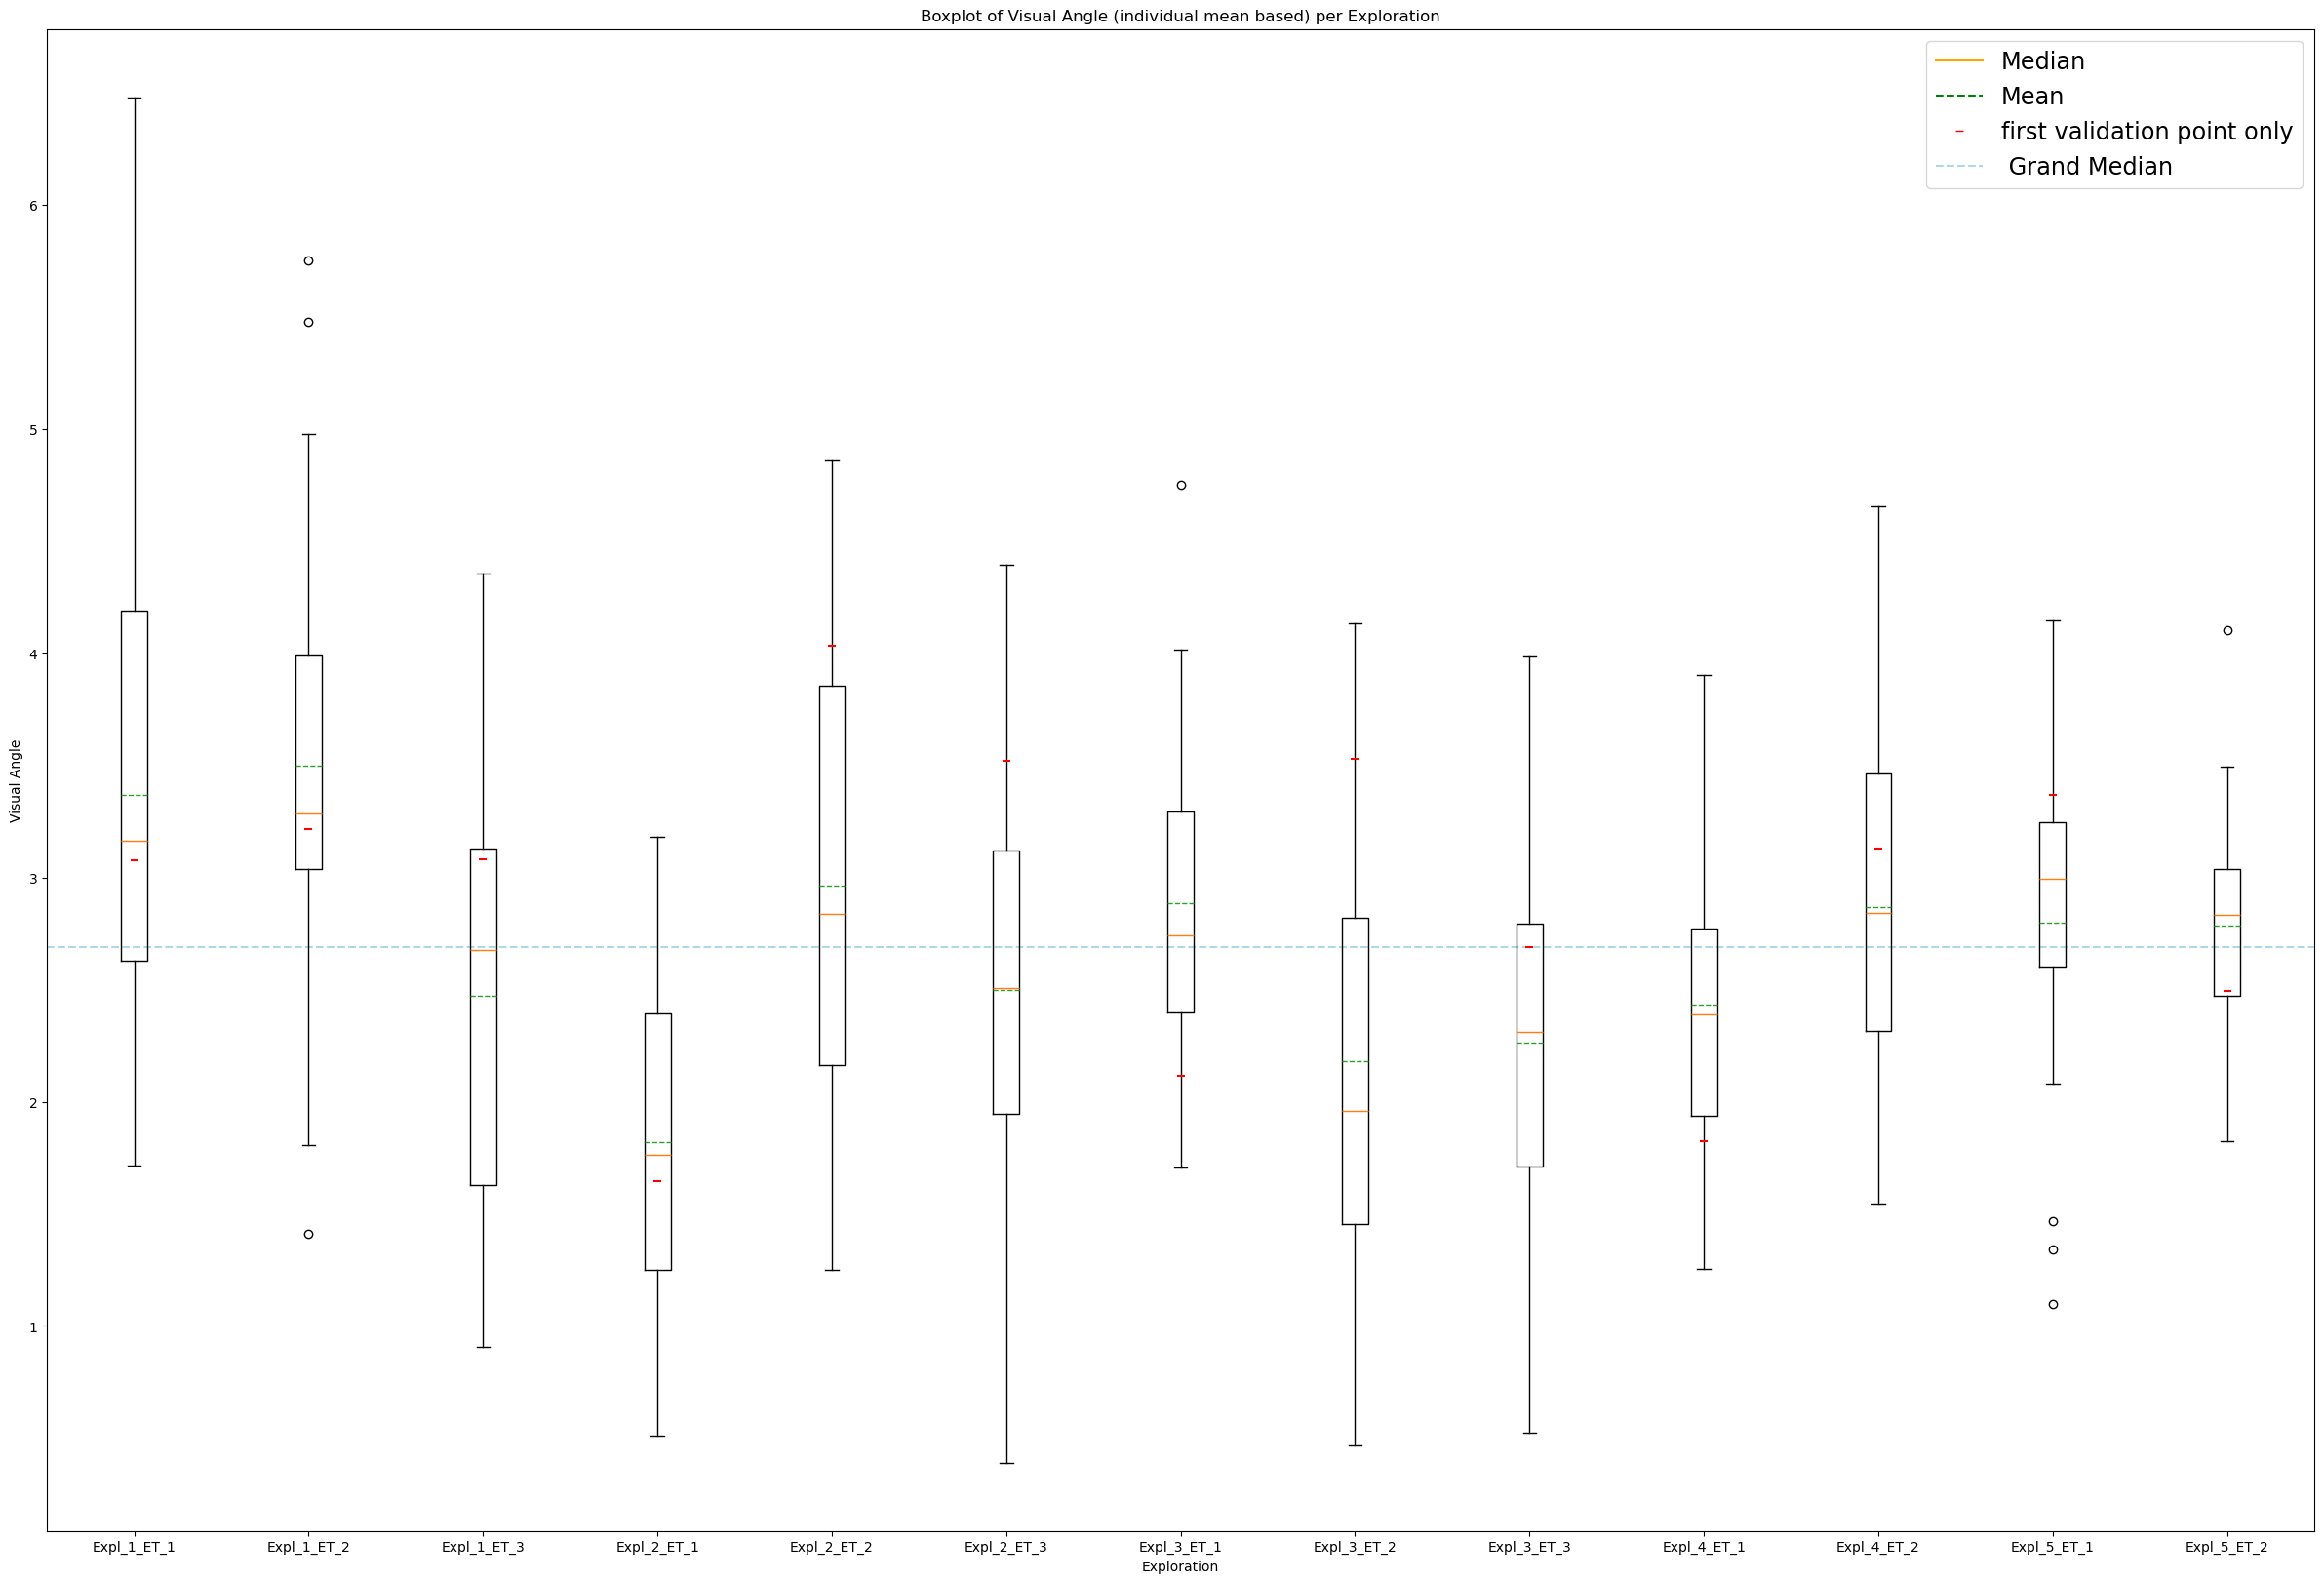

In [21]:
grouped_data = visual_angle_df_w_h_mean_all.groupby('folder')

# Plotting boxplot per folder
i = 0
fig, ax = plt.subplots(figsize=(30,20))

for folder, group in grouped_data:    
    ax.boxplot(group['visual angle'], positions=[i], meanline=True, showmeans=True)
    ax.scatter( folder, group['visual angle'].iloc[0], marker="_", color='red', zorder=3)
    

    i = i + 1
    
#ax.axhline(y=2.5, color="lightgrey", zorder=1, linestyle="-.")   
ax.axhline(y=np.median(visual_angle_df_w_h_mean_all['visual angle']), color="lightblue", zorder=1, linestyle="--")

# Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None', label='first validation point only')
grand_mean_line = plt.Line2D([], [], color='lightblue', linestyle='--', label=' Grand Median')

ax.legend(handles=[median_line, mean_line, single_val_marker, grand_mean_line], loc='upper right', fontsize='xx-large', title='')

ax.set_xticklabels(grouped_data.groups.keys())
ax.set_xlabel('Exploration')
ax.set_ylabel('Visual Angle')
plt.title('Boxplot of Visual Angle (individual mean based) per Exploration')


plt.show()

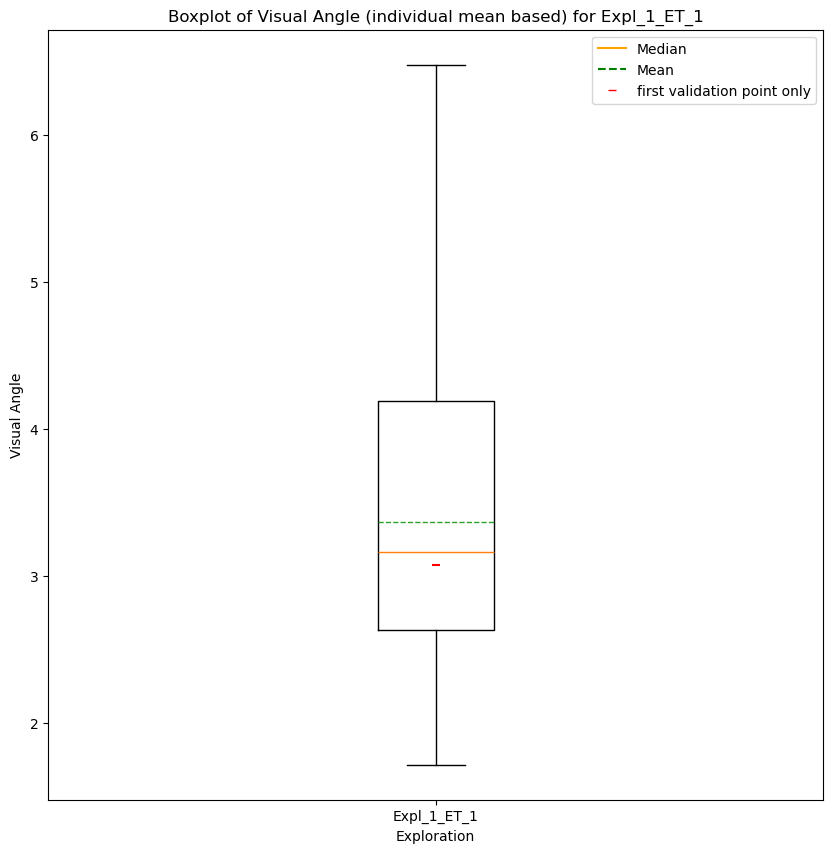

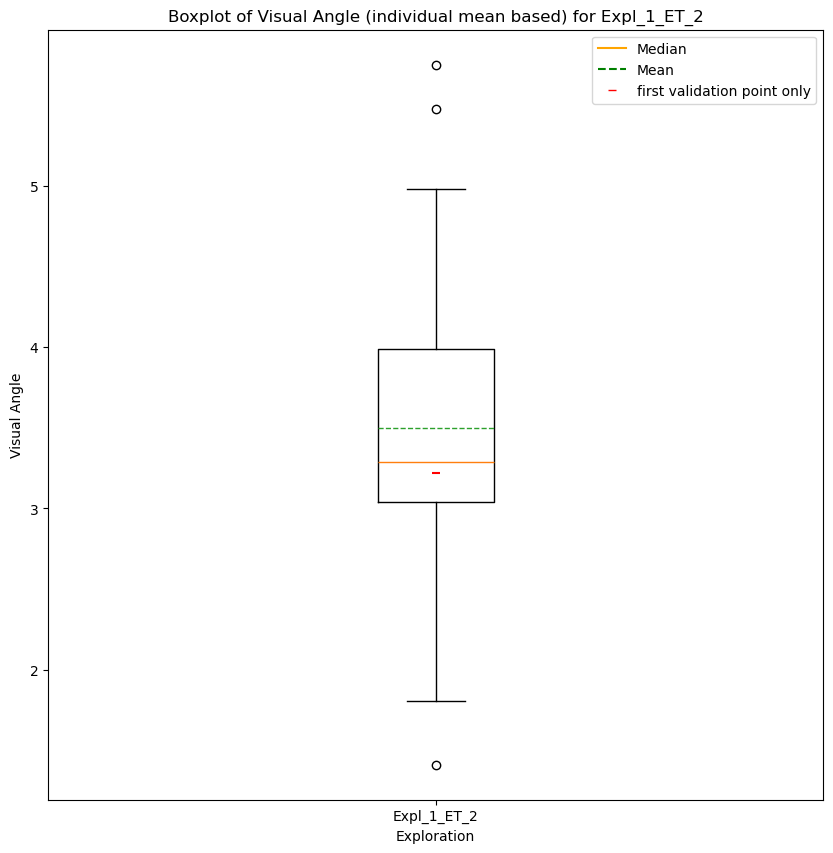

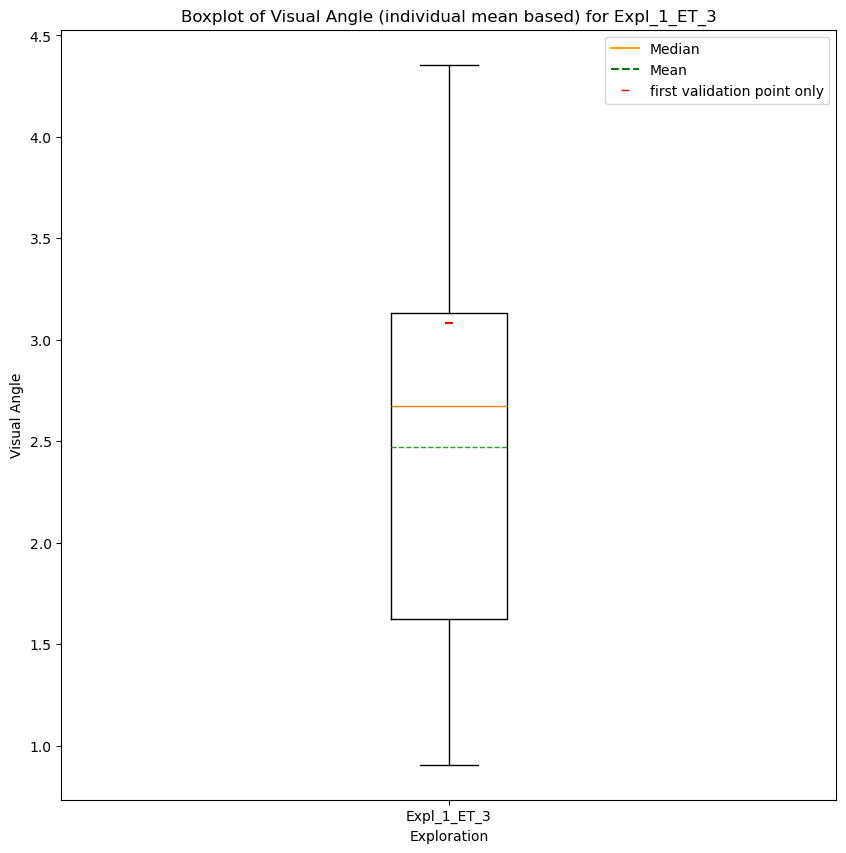

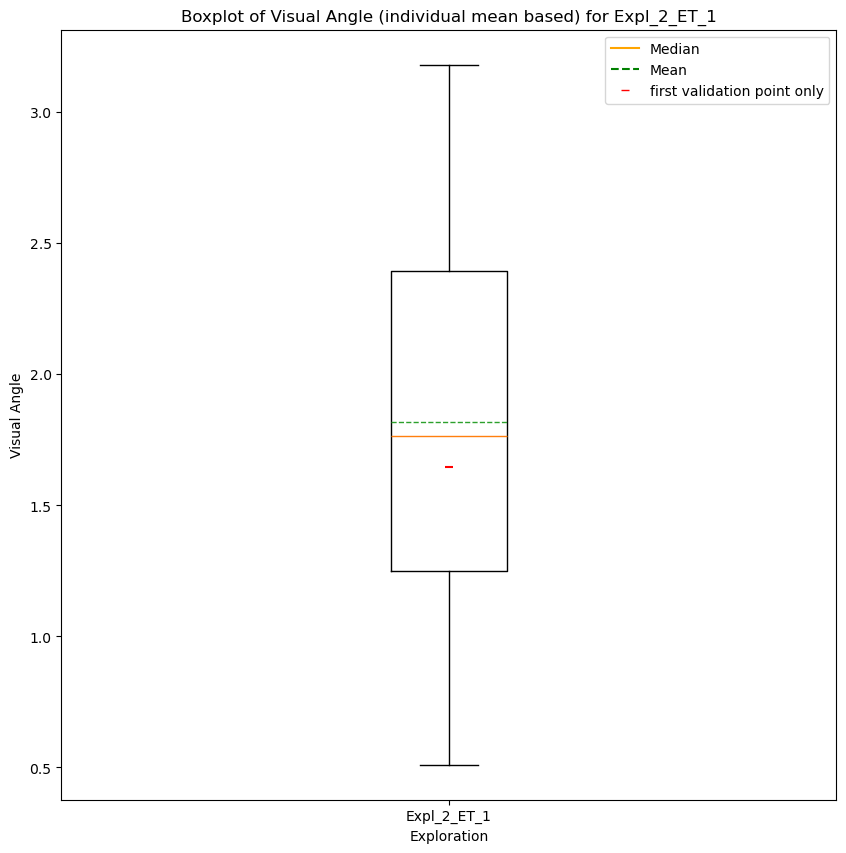

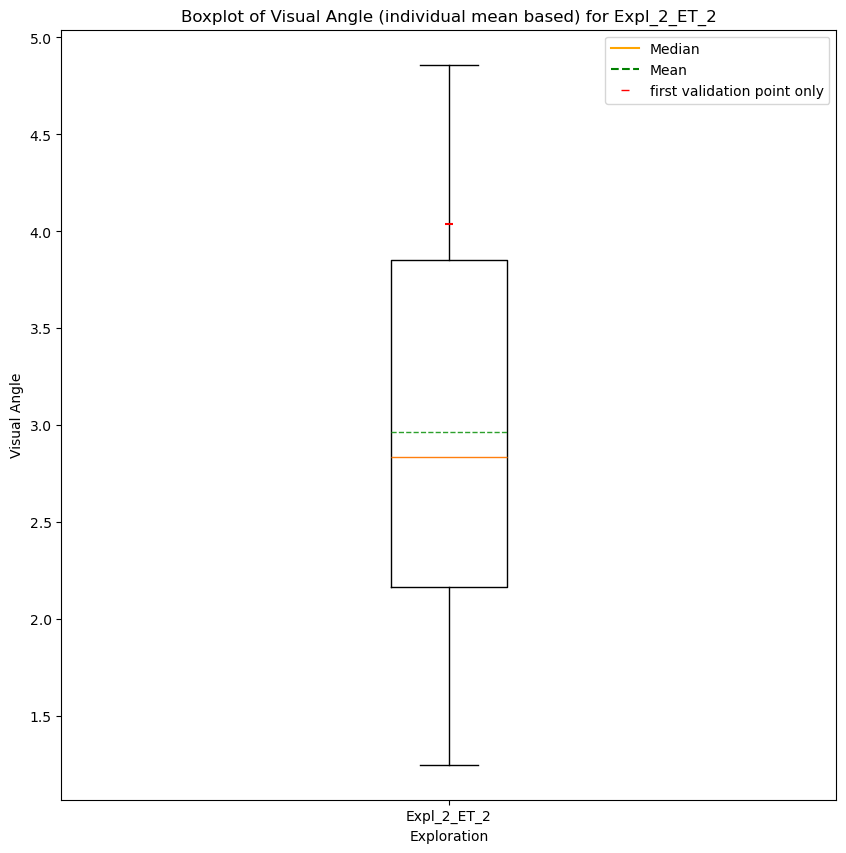

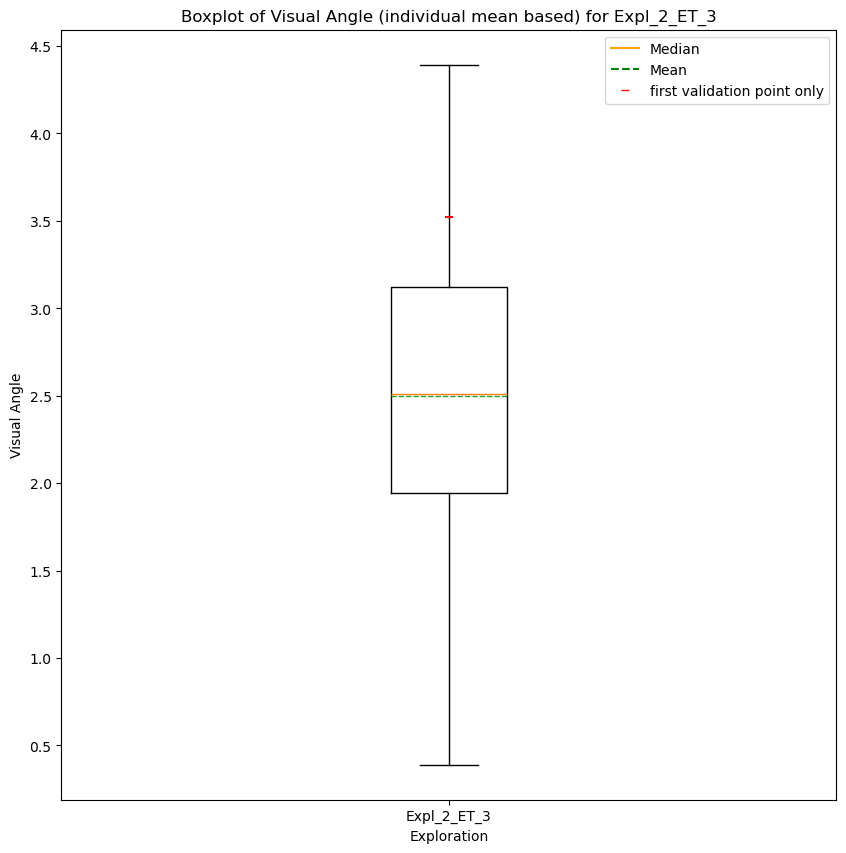

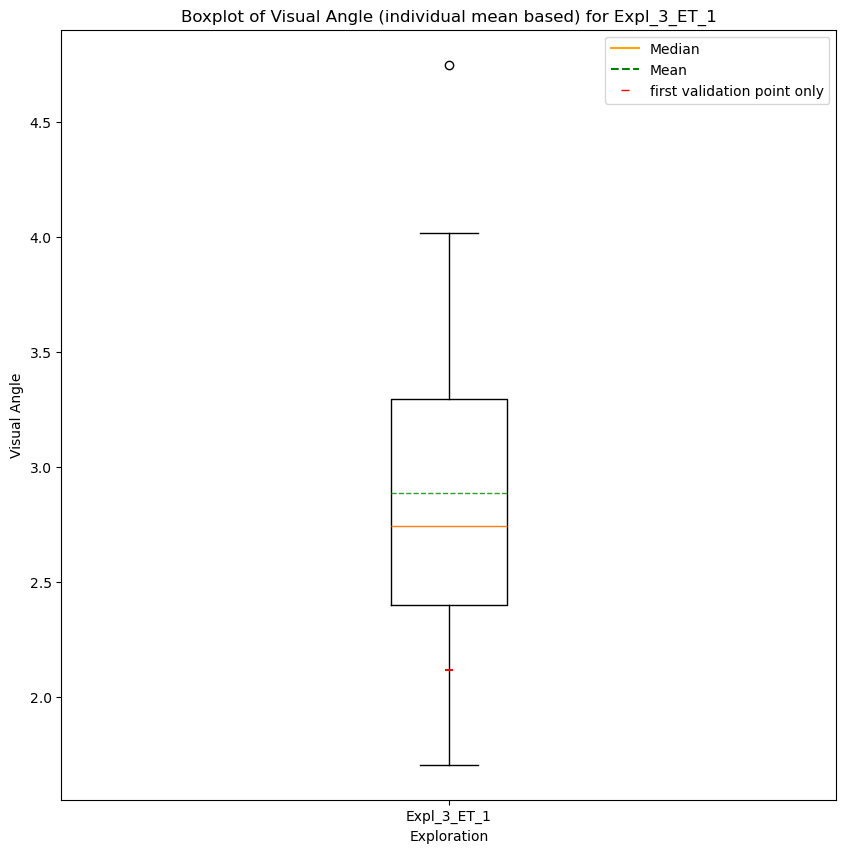

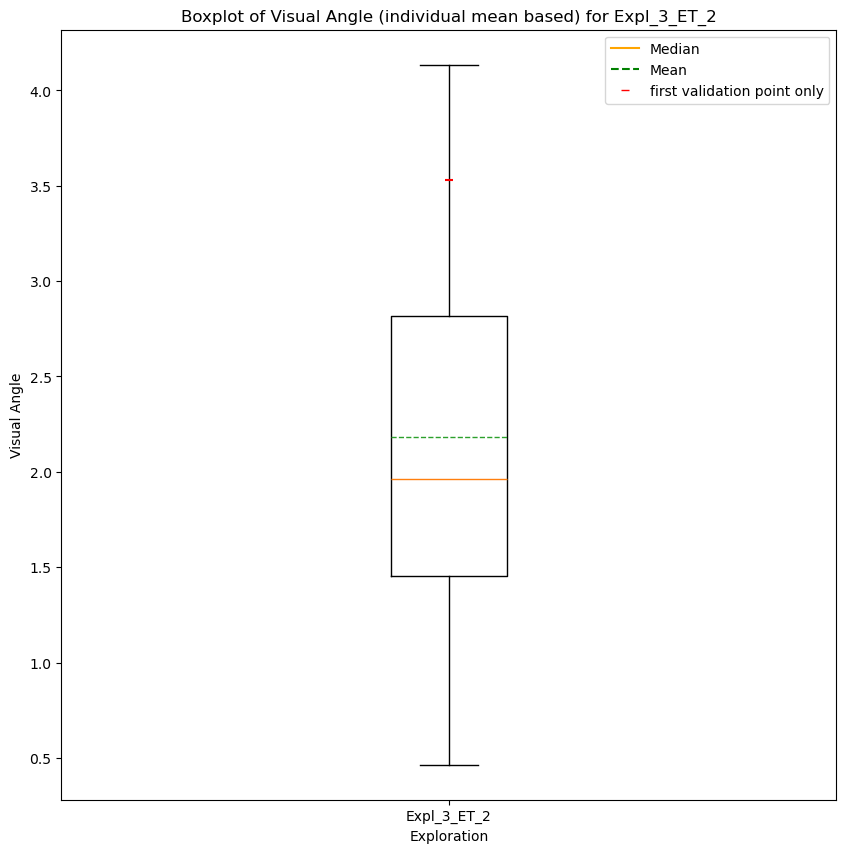

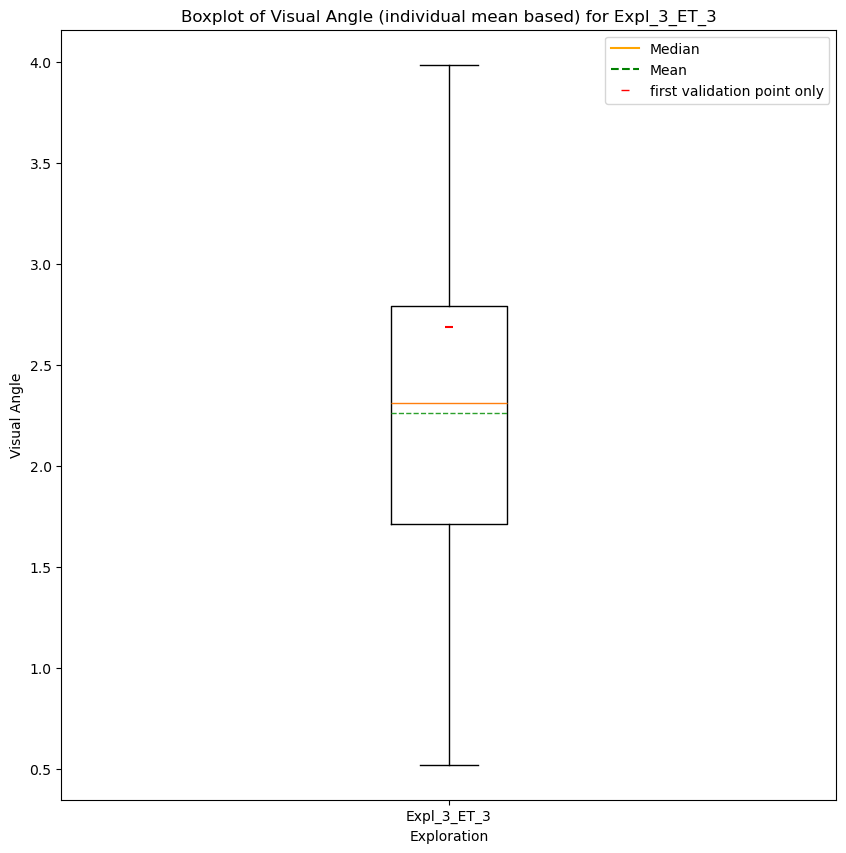

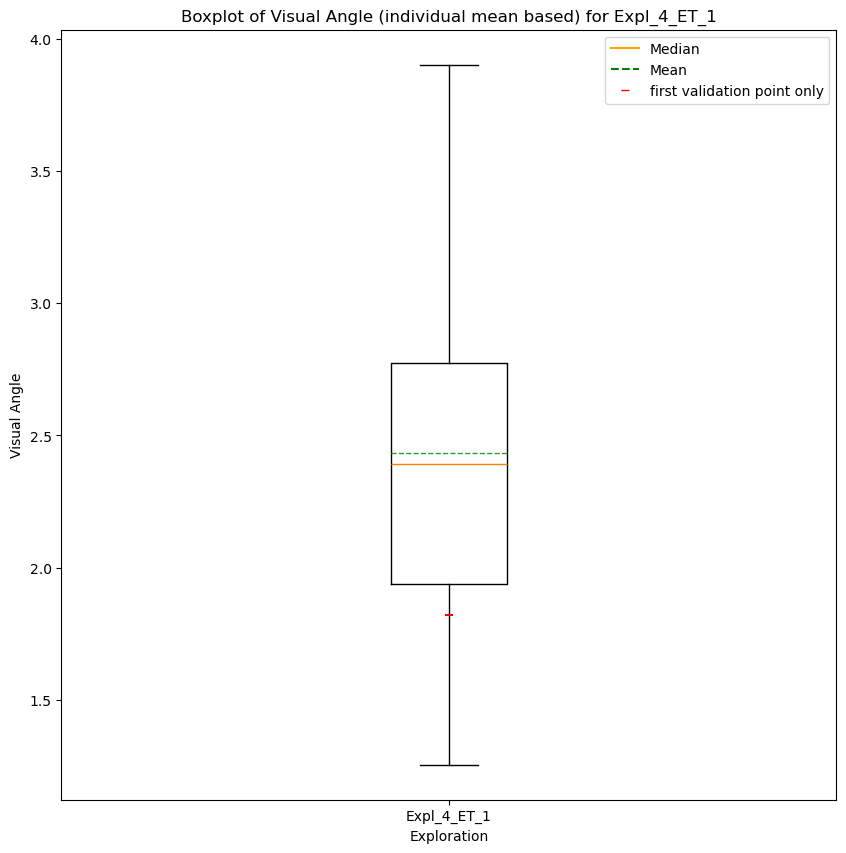

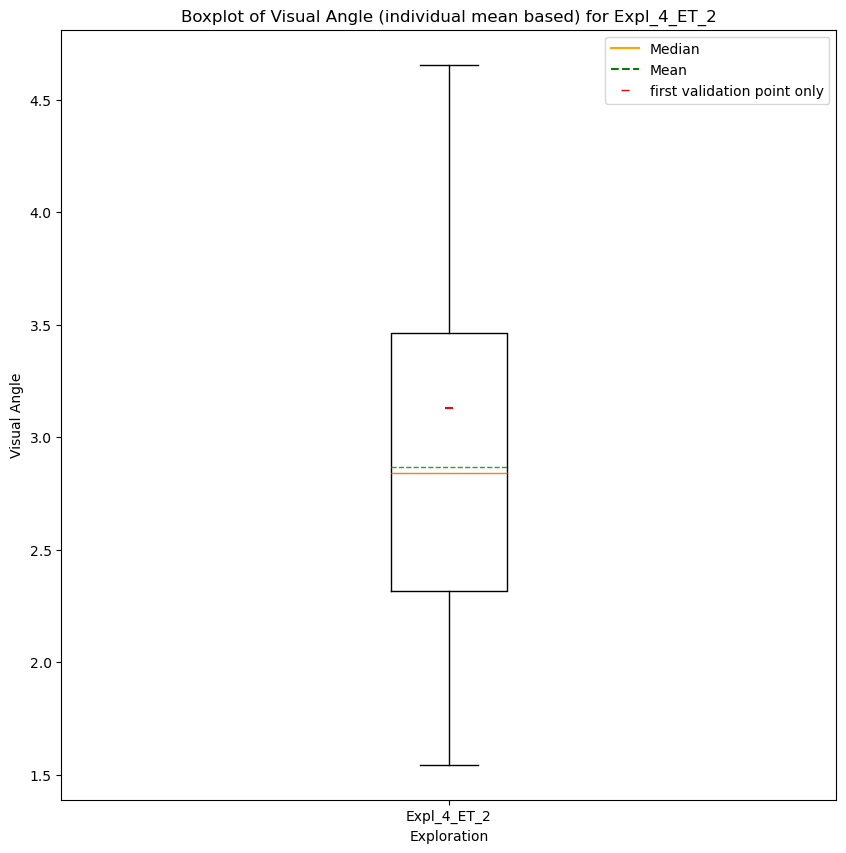

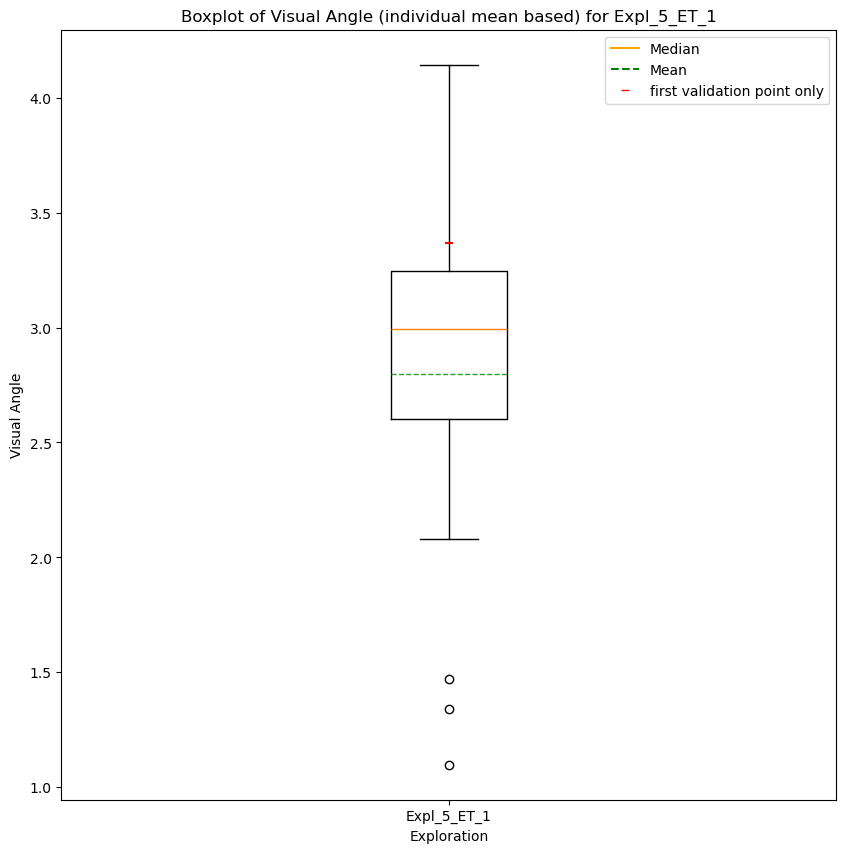

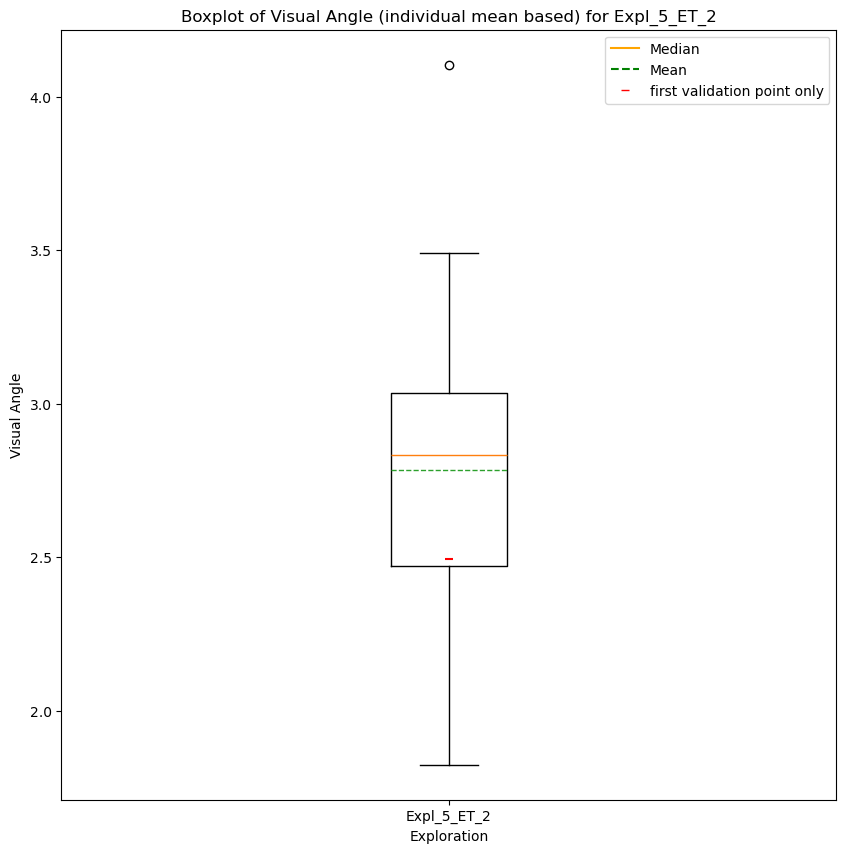

In [22]:
# Grouping by folder
grouped_data = visual_angle_df_w_h_mean_all.groupby('folder')
i=0

# Create separate plots for each folder
for folder, group in grouped_data:
    
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figsize as needed
    
    ax.boxplot(group['visual angle'], positions=[0], meanline=True, showmeans=True)
    ax.scatter([0], group['visual angle'].iloc[0], marker="_", color='red', zorder=3)
    
    # Adding the custom legend
    median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
    mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
    single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None', label='first validation point only')

    ax.legend(handles=[median_line, mean_line, single_val_marker], loc='upper right', fontsize='medium', title='')

    
    
    ax.set_title(f'Boxplot of Visual Angle (individual mean based) for {folder}')
    ax.set
    ax.set_ylabel('Visual Angle')
    ax.set_xticklabels([folder])  # Set folder name as xticklabel
    ax.set_xlabel('Exploration')
    i = i+1

    plt.show()


## Start validations only

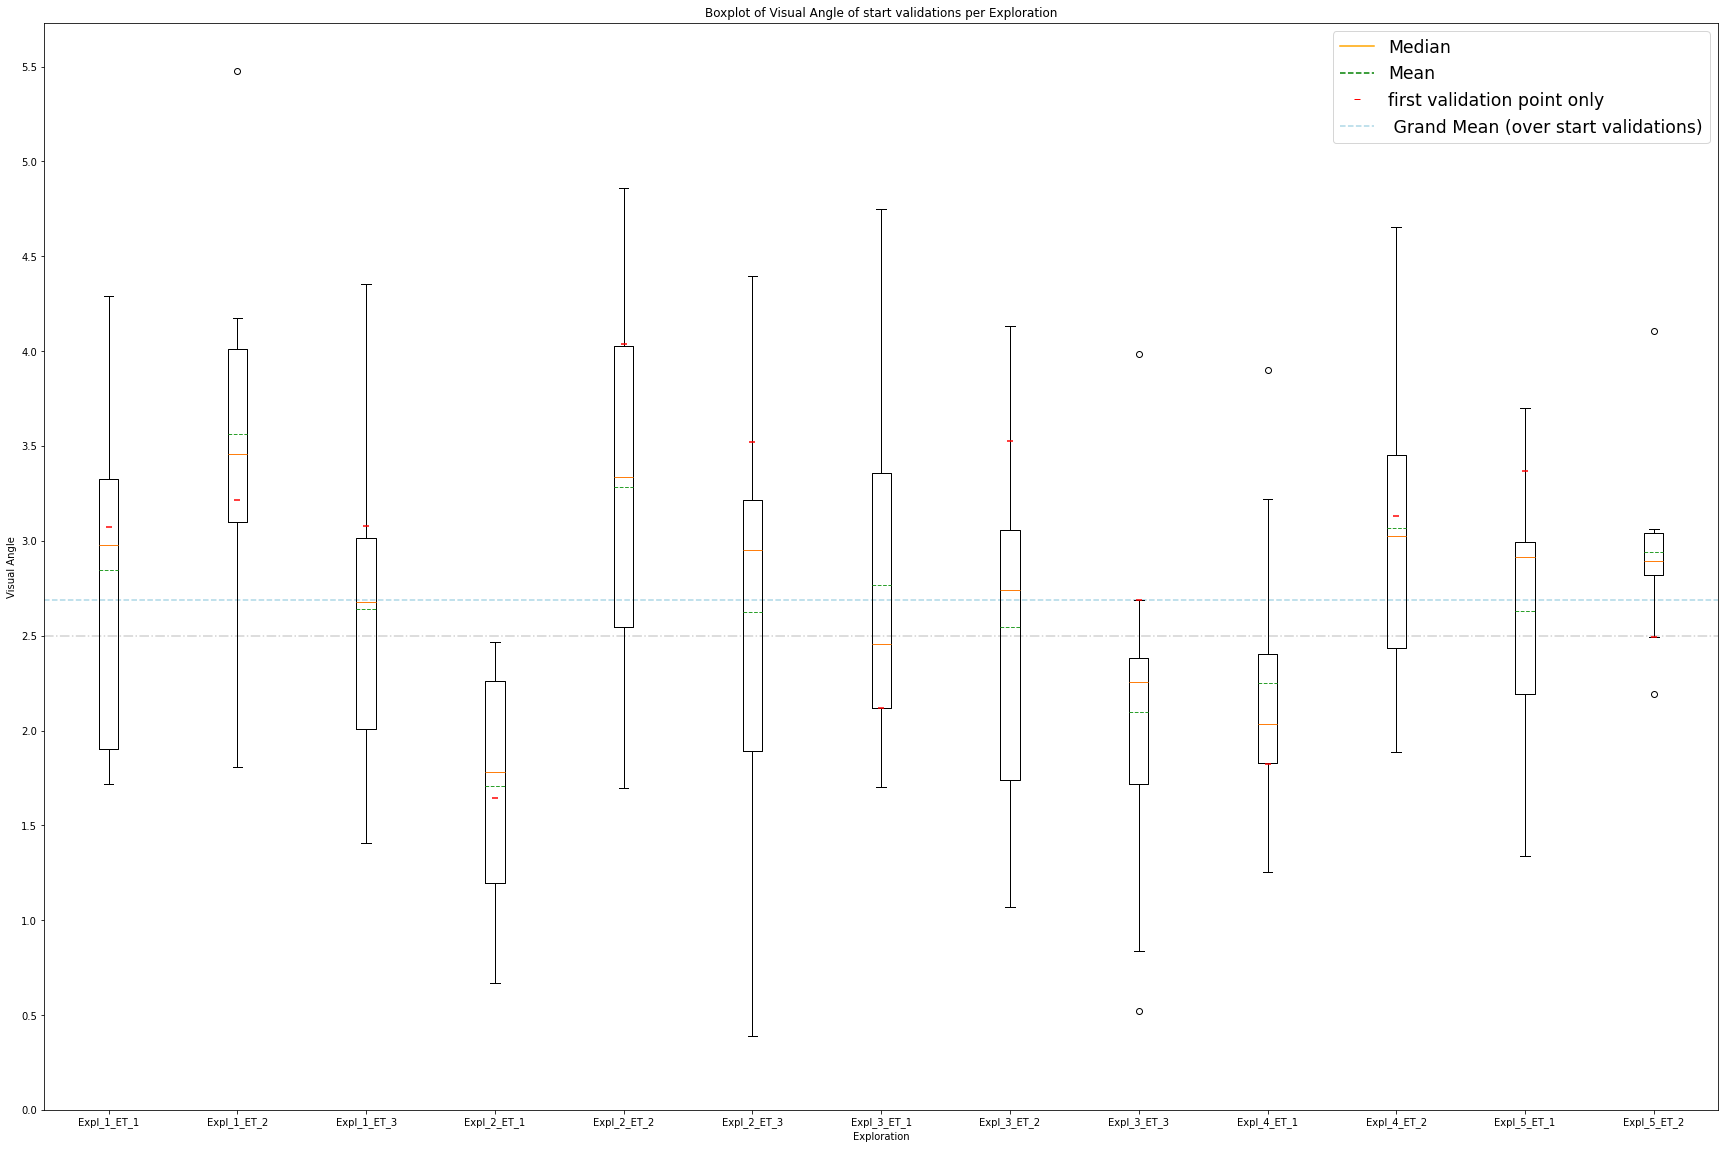

In [39]:
start_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

grouped_data = start_val_df.groupby('folder')

first_val_points = []

for index, row in start_val_df.iterrows():
    if '1' in row['label_start']:
        if '10' not in row['label_start']:
            first_val_points.append(row)


# Plotting boxplot per folder
i = 0
fig, ax = plt.subplots(figsize=(30,20))

for folder, group in grouped_data:    
    ax.boxplot(group['VA_start'], positions=[i], meanline=True, showmeans=True)
    ax.scatter( folder, first_val_points[i].loc['VA_start'], marker="_", color='red', zorder=3)
    i=i+1
    
ax.axhline(y=2.5, linestyle="-.",c='lightgrey', zorder=1)
ax.axhline(y=np.mean(start_val_df['VA_start']), color="lightblue", zorder=1, linestyle="--")

    
# Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
grand_mean_line = plt.Line2D([], [], color='lightblue', linestyle='--', label=' Grand Mean (over start validations)')
single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None', label='first validation point only')

ax.legend(handles=[median_line, mean_line, single_val_marker, grand_mean_line], loc='upper right', fontsize='xx-large', title='')

ax.set_xticklabels(grouped_data.groups.keys())
ax.set_yticks(np.arange(0,6, step=0.5))
ax.set_xlabel('Exploration')
ax.set_ylabel('Visual Angle')

plt.title('Boxplot of Visual Angle of start validations per Exploration')

plt.show()

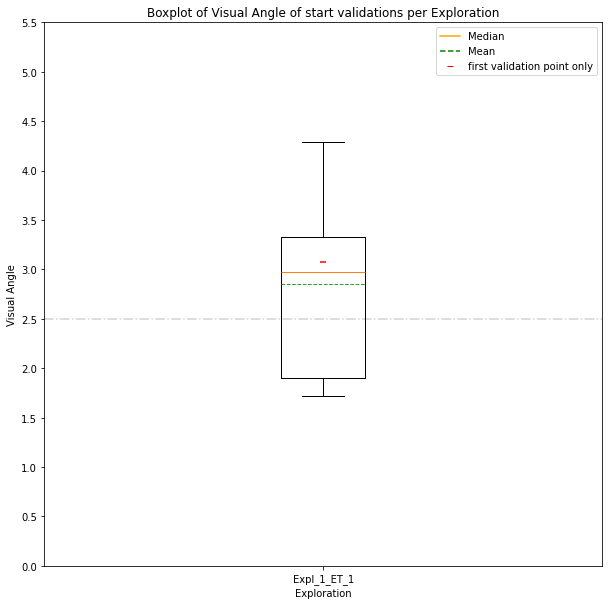

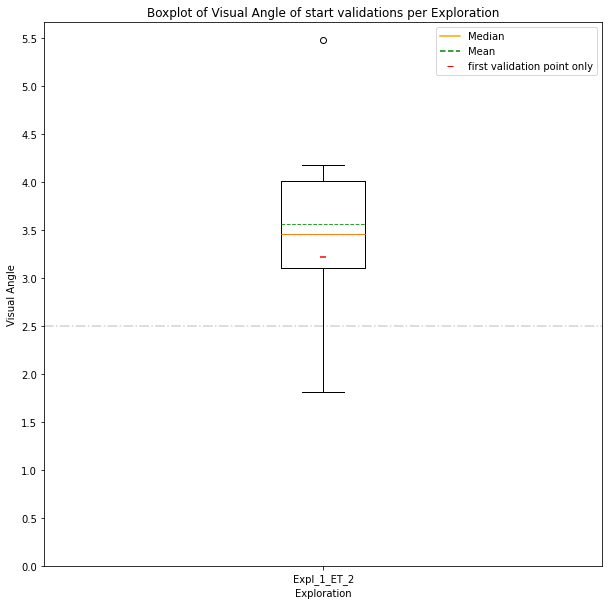

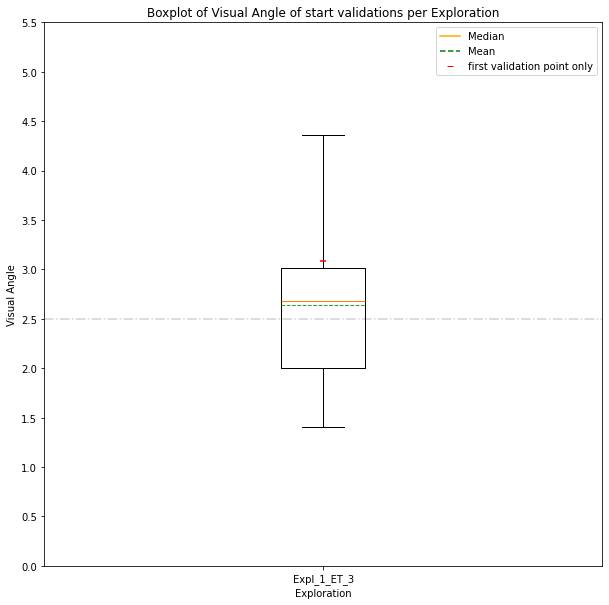

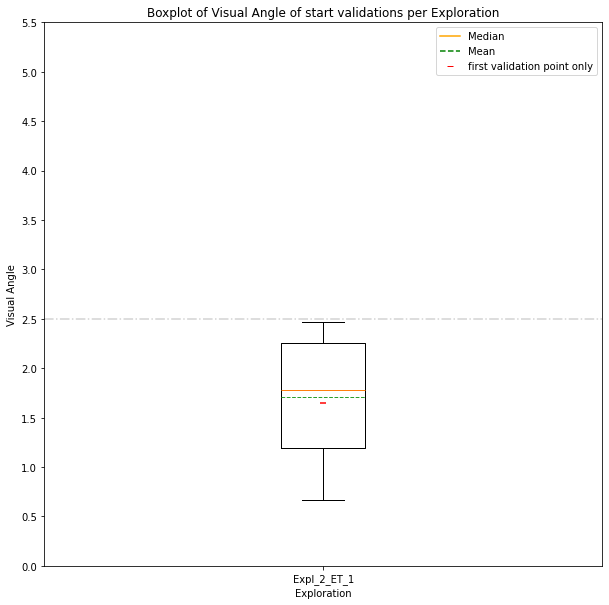

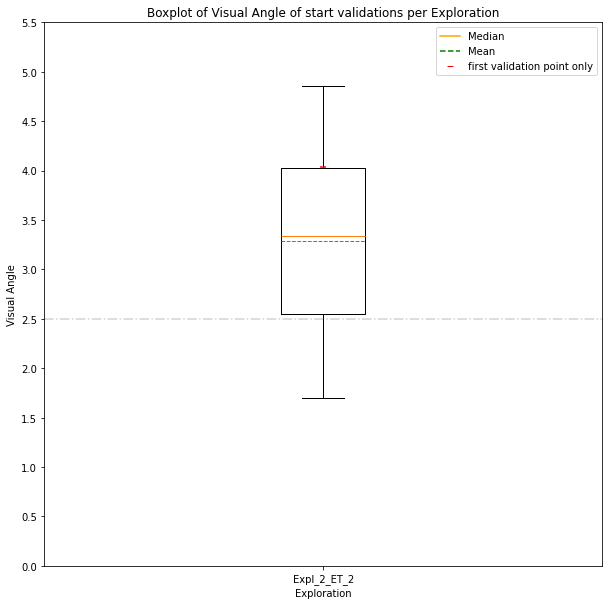

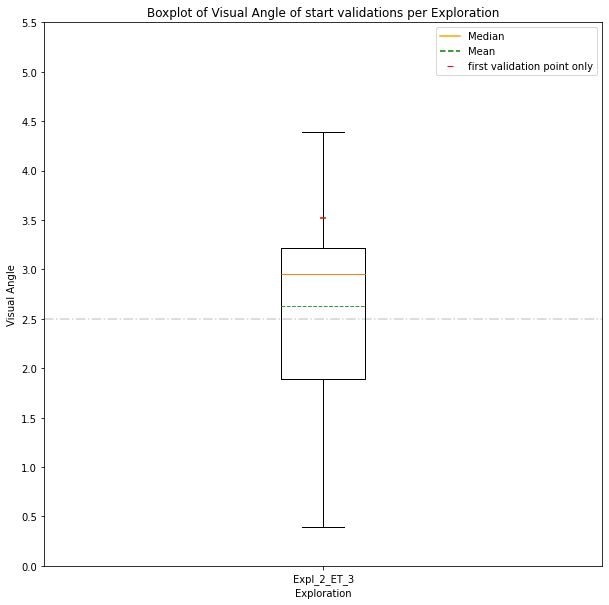

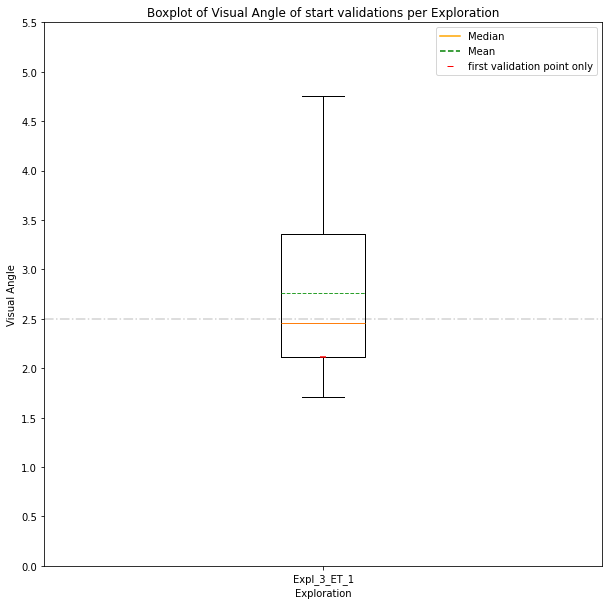

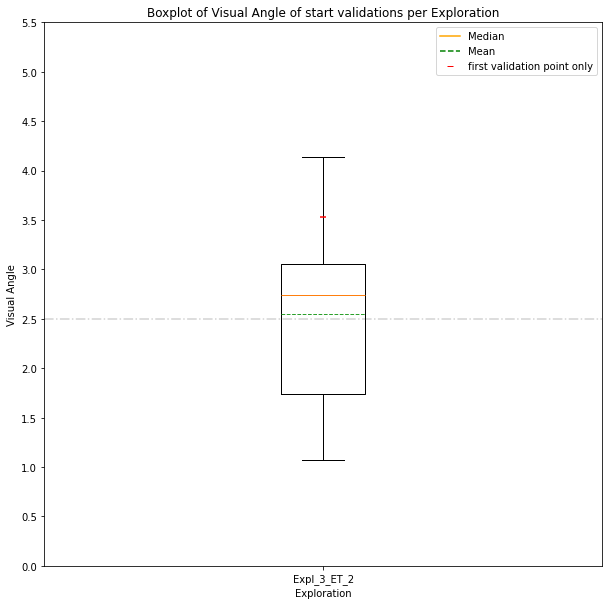

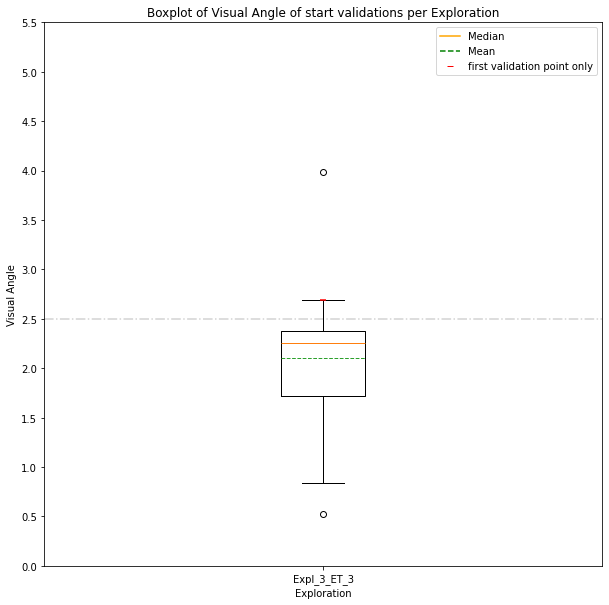

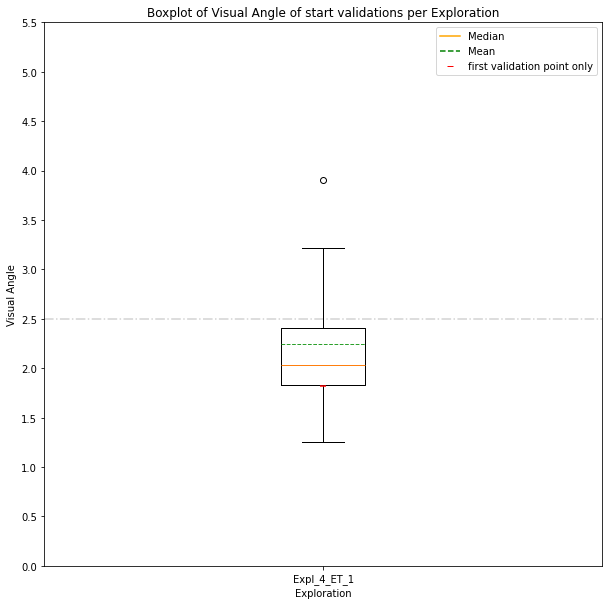

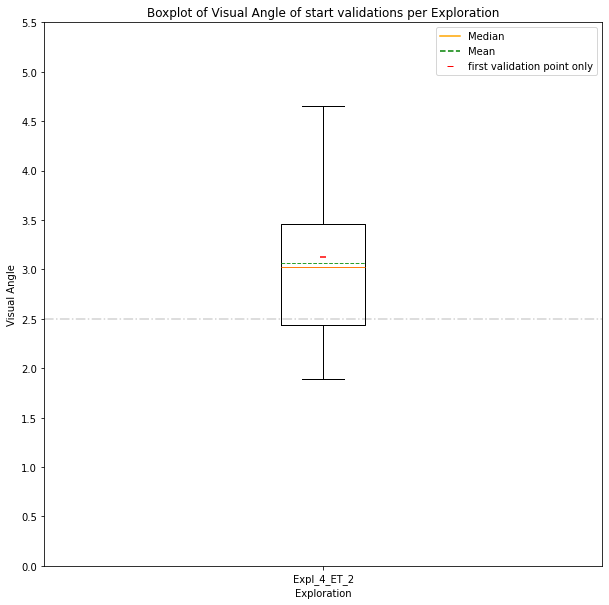

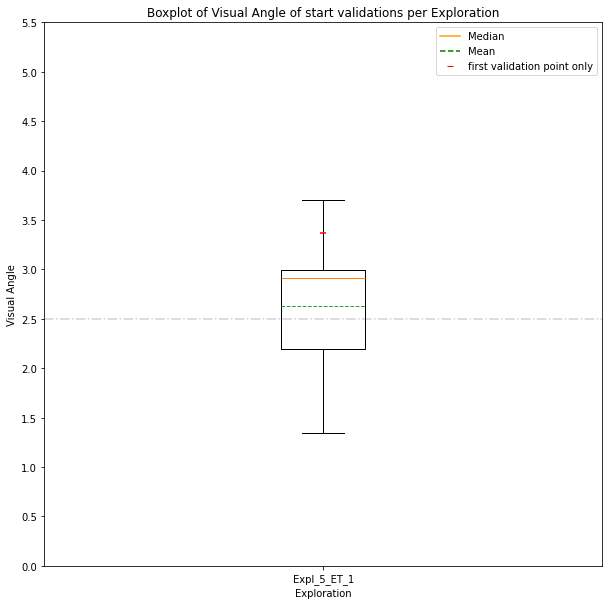

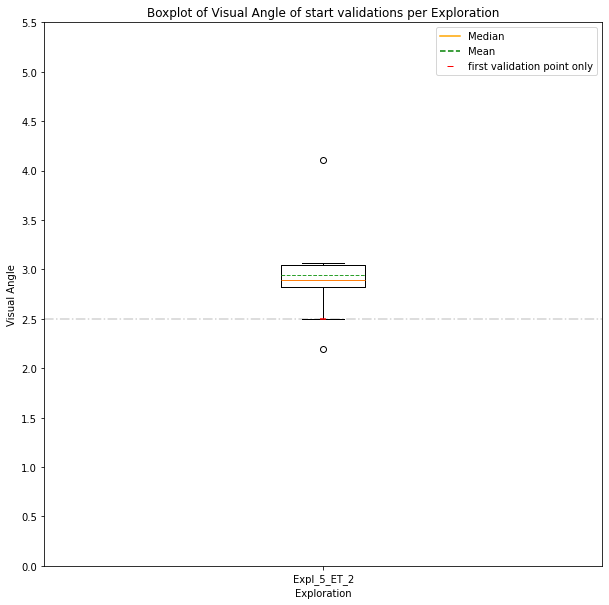

In [18]:
start_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

grouped_data = start_val_df.groupby('folder')

first_val_points = []

for index, row in start_val_df.iterrows():
    if '1' in row['label_start']:
        if '10' not in row['label_start']:
            first_val_points.append(row)


# Plotting boxplot per folder
i = 0


for folder, group in grouped_data:    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(group['VA_start'], positions=[0], meanline=True, showmeans=True)
    ax.scatter([0], first_val_points[i].loc['VA_start'], marker="_", color='red', zorder=3)
    ax.axhline(y=2.5, linestyle="-.",c='lightgrey', zorder=1)
    i=i+1
    
# Adding the custom legend
    median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
    mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
    single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None', label='first validation point only')
    
    ax.legend(handles=[median_line, mean_line, single_val_marker], loc='upper right', fontsize='medium', title='')

    ax.set_xticklabels([folder])
    ax.set_yticks(np.arange(0,6, step=0.5))
    ax.set_xlabel('Exploration')
    ax.set_ylabel('Visual Angle')

    plt.title('Boxplot of Visual Angle of start validations per Exploration')

    plt.show()

## End validations only

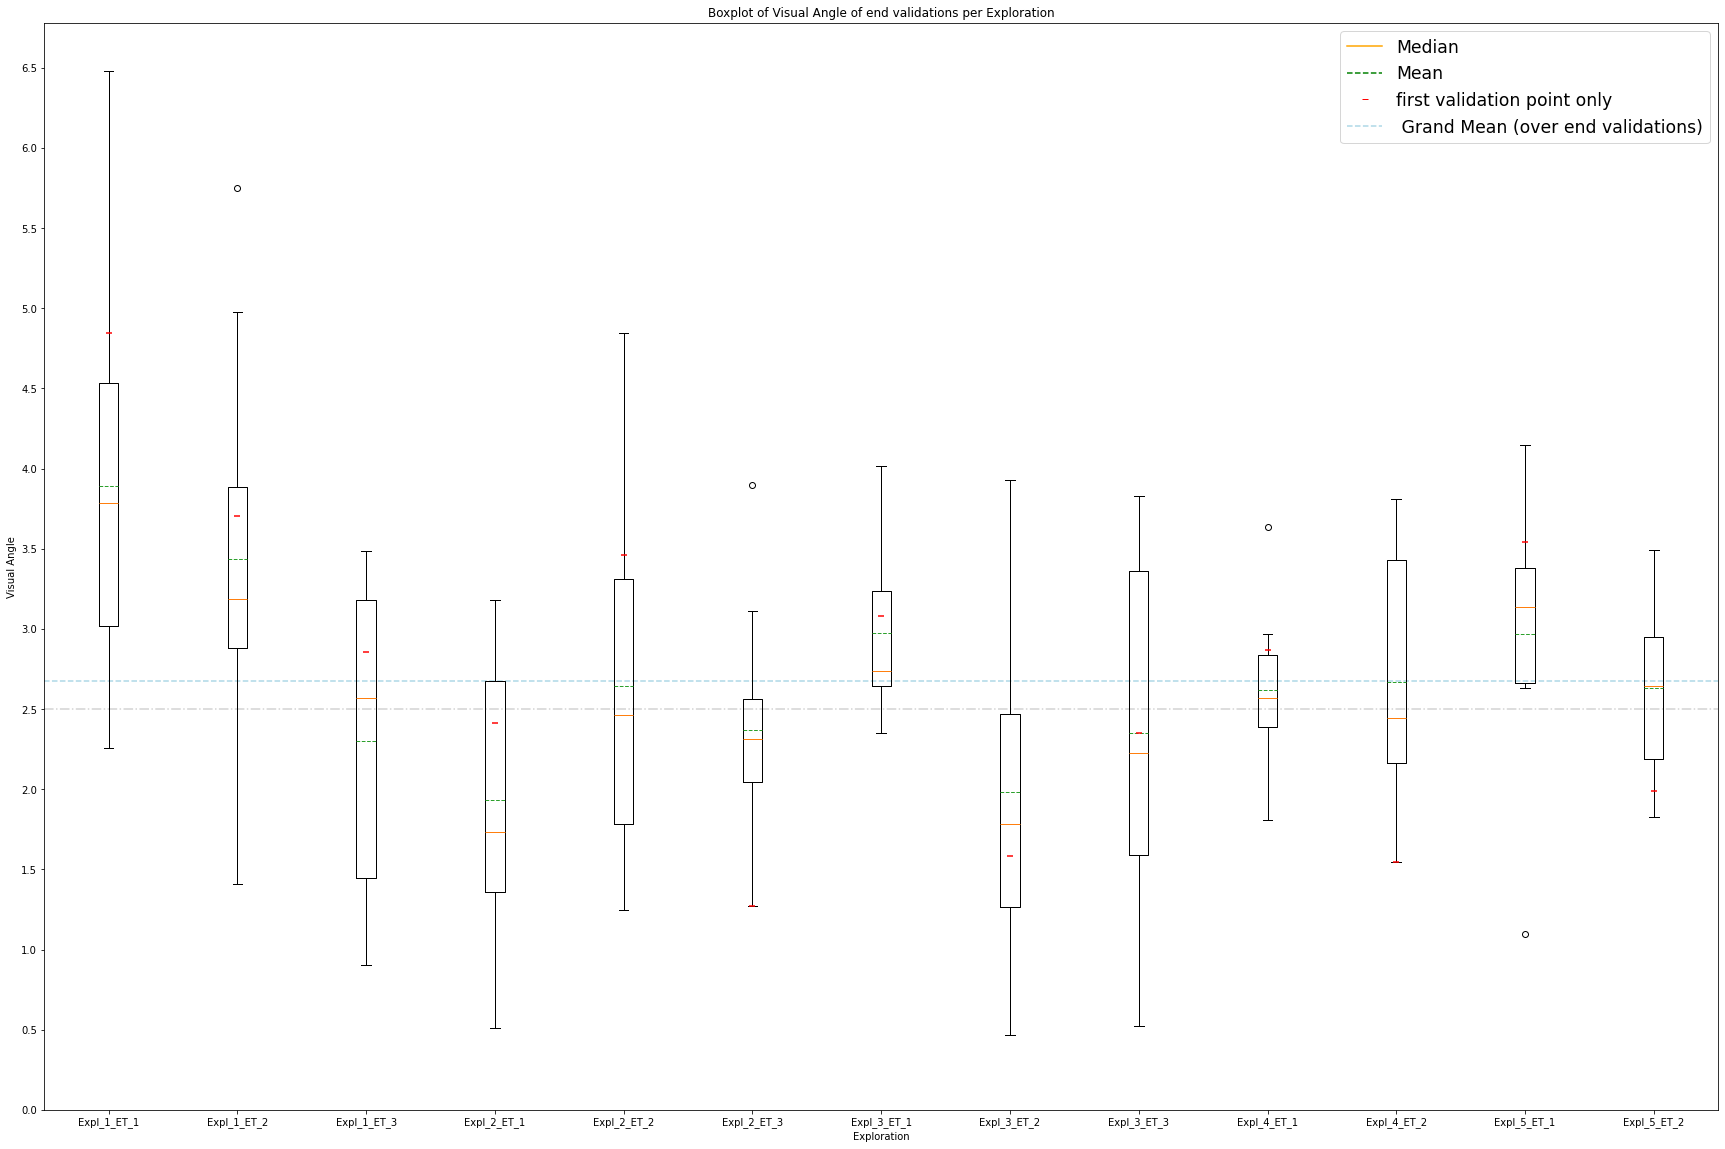

In [43]:
end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

grouped_data = end_val_df.groupby('folder')

first_val_points = []

for index, row in end_val_df.iterrows():
    if '1' in row['label_end']:
        if '10' not in row['label_end']:
            first_val_points.append(row)


# Plotting boxplot per folder
i = 0
fig, ax = plt.subplots(figsize=(30,20))

for folder, group in grouped_data:    
    ax.boxplot(group['VA_end'], positions=[i], meanline=True, showmeans=True)
    ax.scatter( folder, first_val_points[i].loc['VA_end'], marker="_", color='red', zorder=3)
    i=i+1
    
ax.axhline(y=2.5, linestyle="-.",c='lightgrey', zorder=1)
ax.axhline(y=np.mean(end_val_df['VA_end']), color="lightblue", zorder=1, linestyle="--")

# Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None',  label='first validation point only')
grand_mean_line = plt.Line2D([], [], color='lightblue', linestyle='--', label=' Grand Mean (over end validations)')

ax.legend(handles=[median_line, mean_line, single_val_marker, grand_mean_line], loc='upper right', fontsize='xx-large', title='')
    

ax.set_xticklabels(grouped_data.groups.keys())
ax.set_yticks(np.arange(0,7, step=0.5))
ax.set_xlabel('Exploration')
ax.set_ylabel('Visual Angle')

plt.title('Boxplot of Visual Angle of end validations per Exploration')
plt.show()

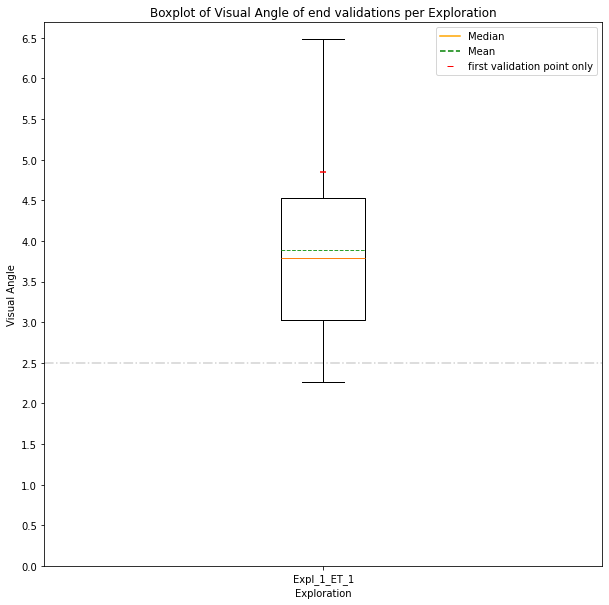

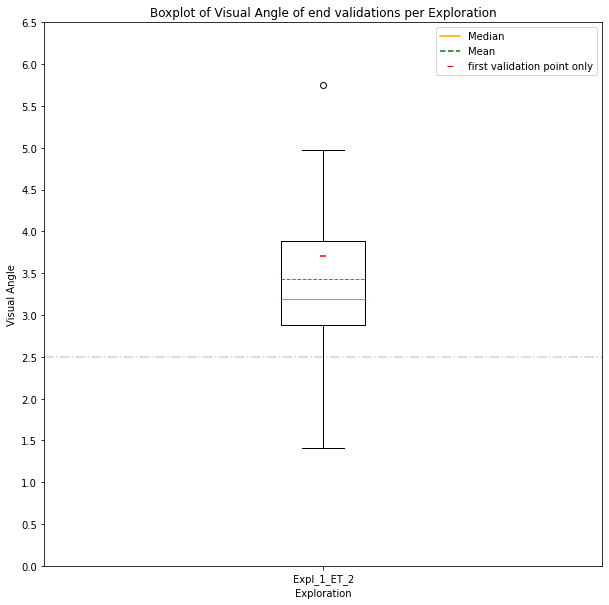

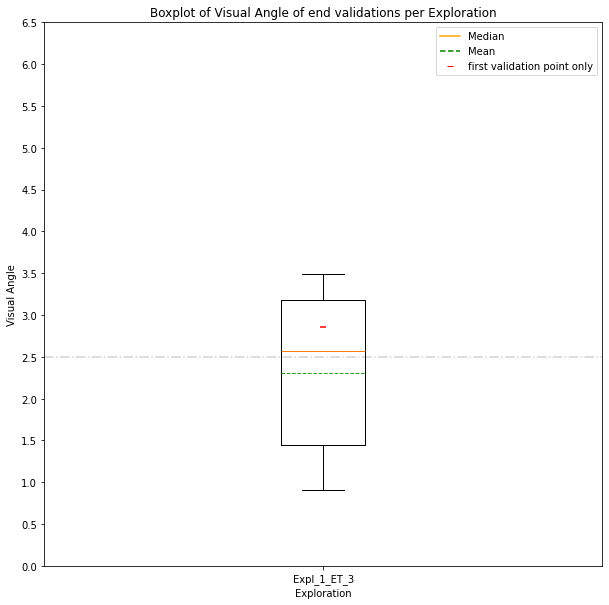

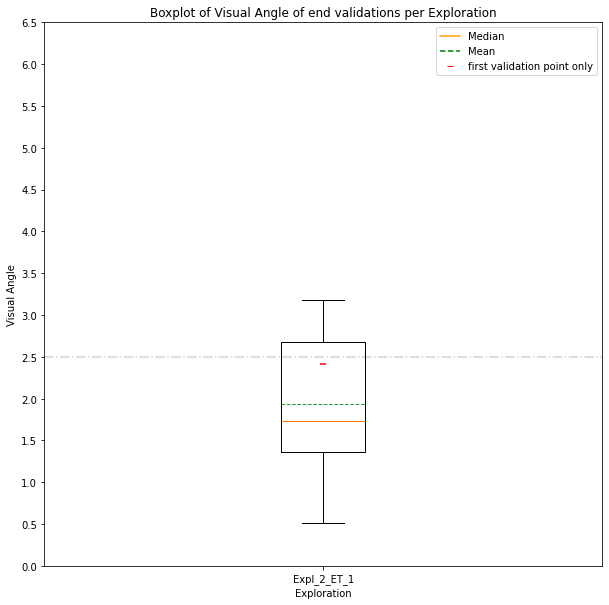

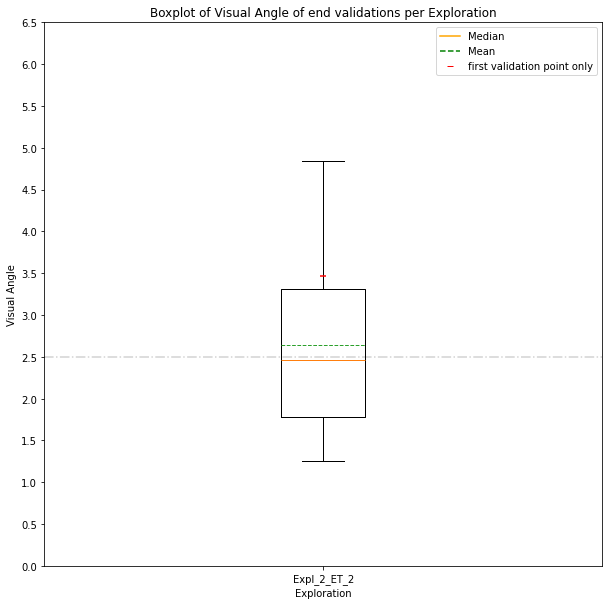

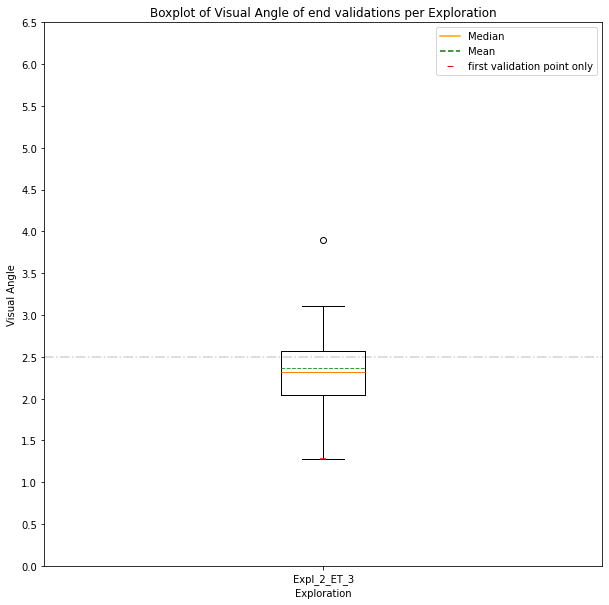

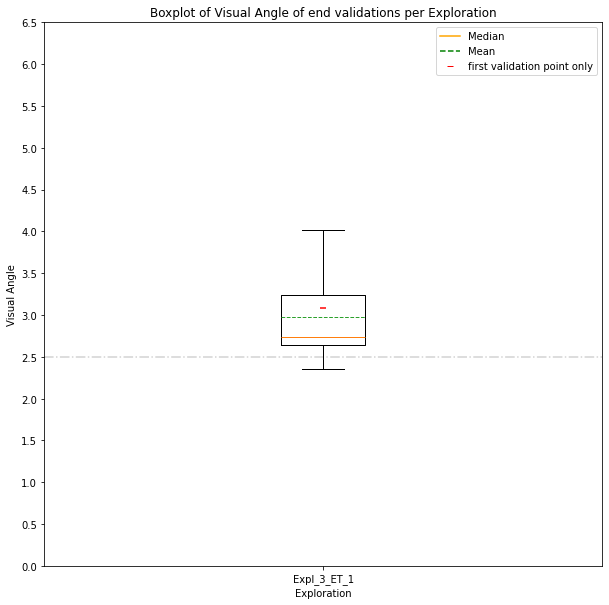

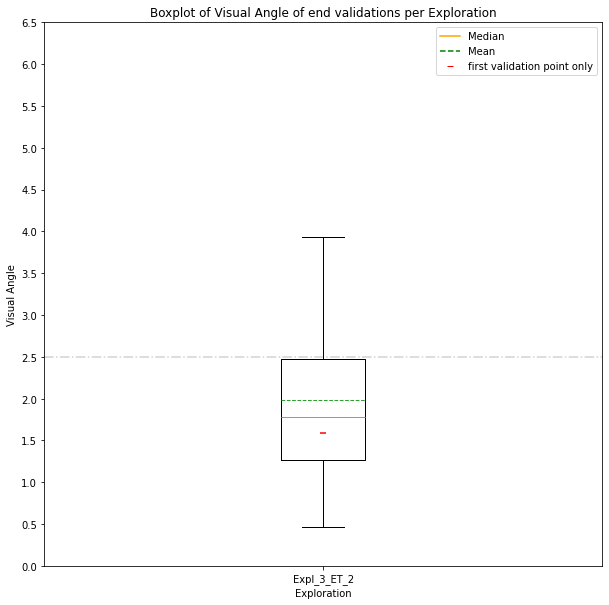

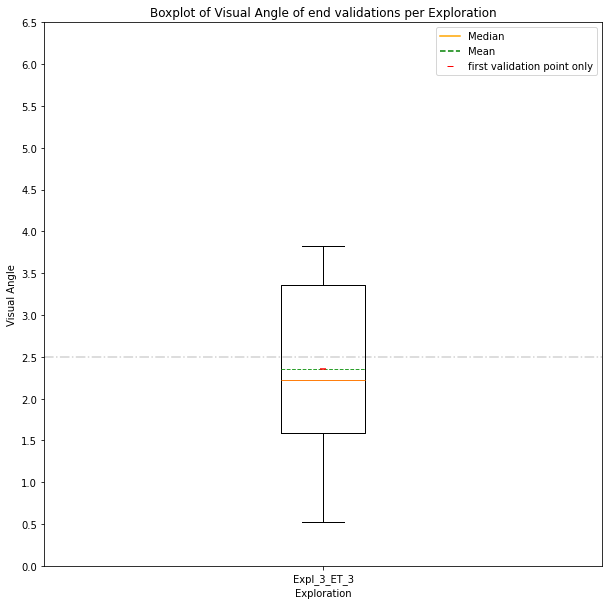

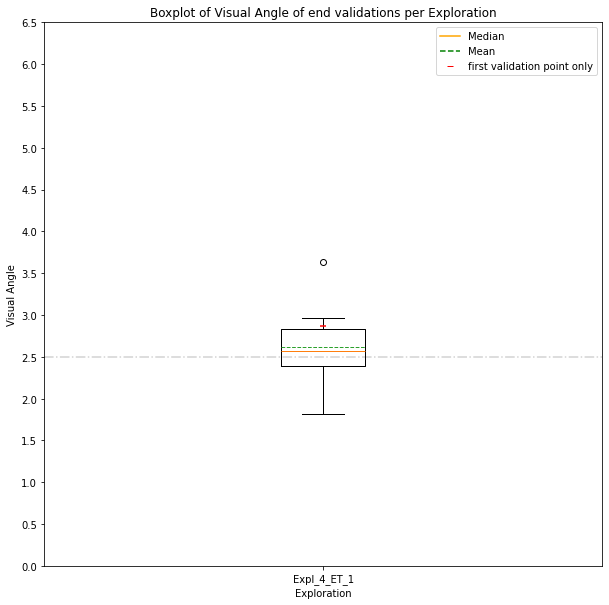

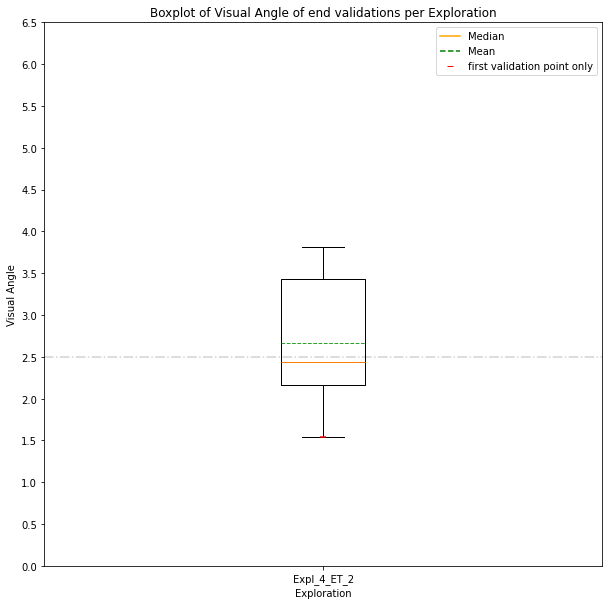

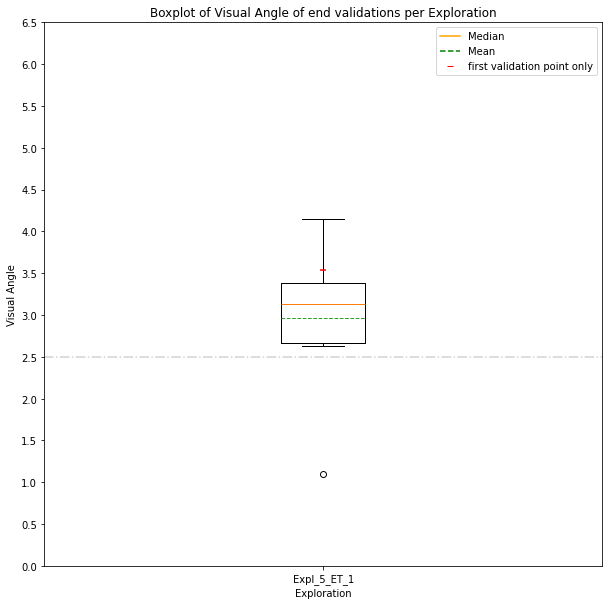

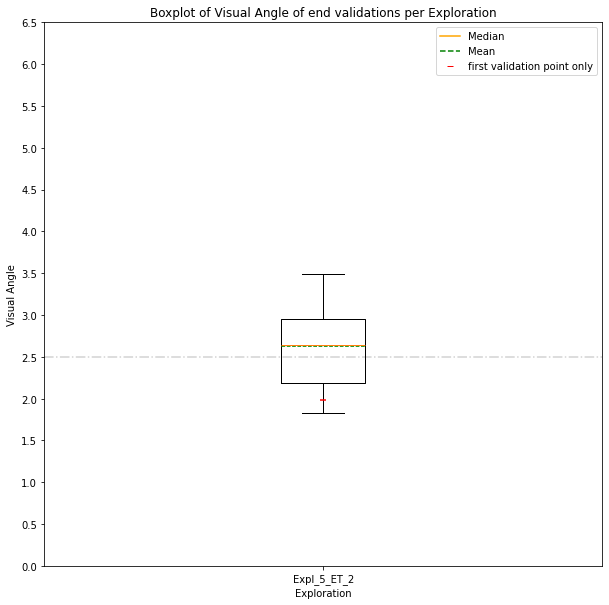

In [20]:
end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

grouped_data = end_val_df.groupby('folder')

first_val_points = []

for index, row in end_val_df.iterrows():
    if '1' in row['label_end']:
        if '10' not in row['label_end']:
            first_val_points.append(row)


# Plotting boxplot per folder
i = 0


for folder, group in grouped_data:    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(group['VA_end'], positions=[0], meanline=True, showmeans=True)
    ax.scatter( [0], first_val_points[i].loc['VA_end'], marker="_", color='red', zorder=3)
    ax.axhline(y=2.5, linestyle="-.",c='lightgrey', zorder=1)
    i=i+1

    # Adding the custom legend
    median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
    mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
    single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None',  label='first validation point only')

    ax.legend(handles=[median_line, mean_line, single_val_marker], loc='upper right', fontsize='medium', title='')


    ax.set_xticklabels([folder])
    ax.set_yticks(np.arange(0,7, step=0.5))
    ax.set_xlabel('Exploration')
    ax.set_ylabel('Visual Angle')

    plt.title('Boxplot of Visual Angle of end validations per Exploration')
plt.show()

## Ploting the difference between start and end validations

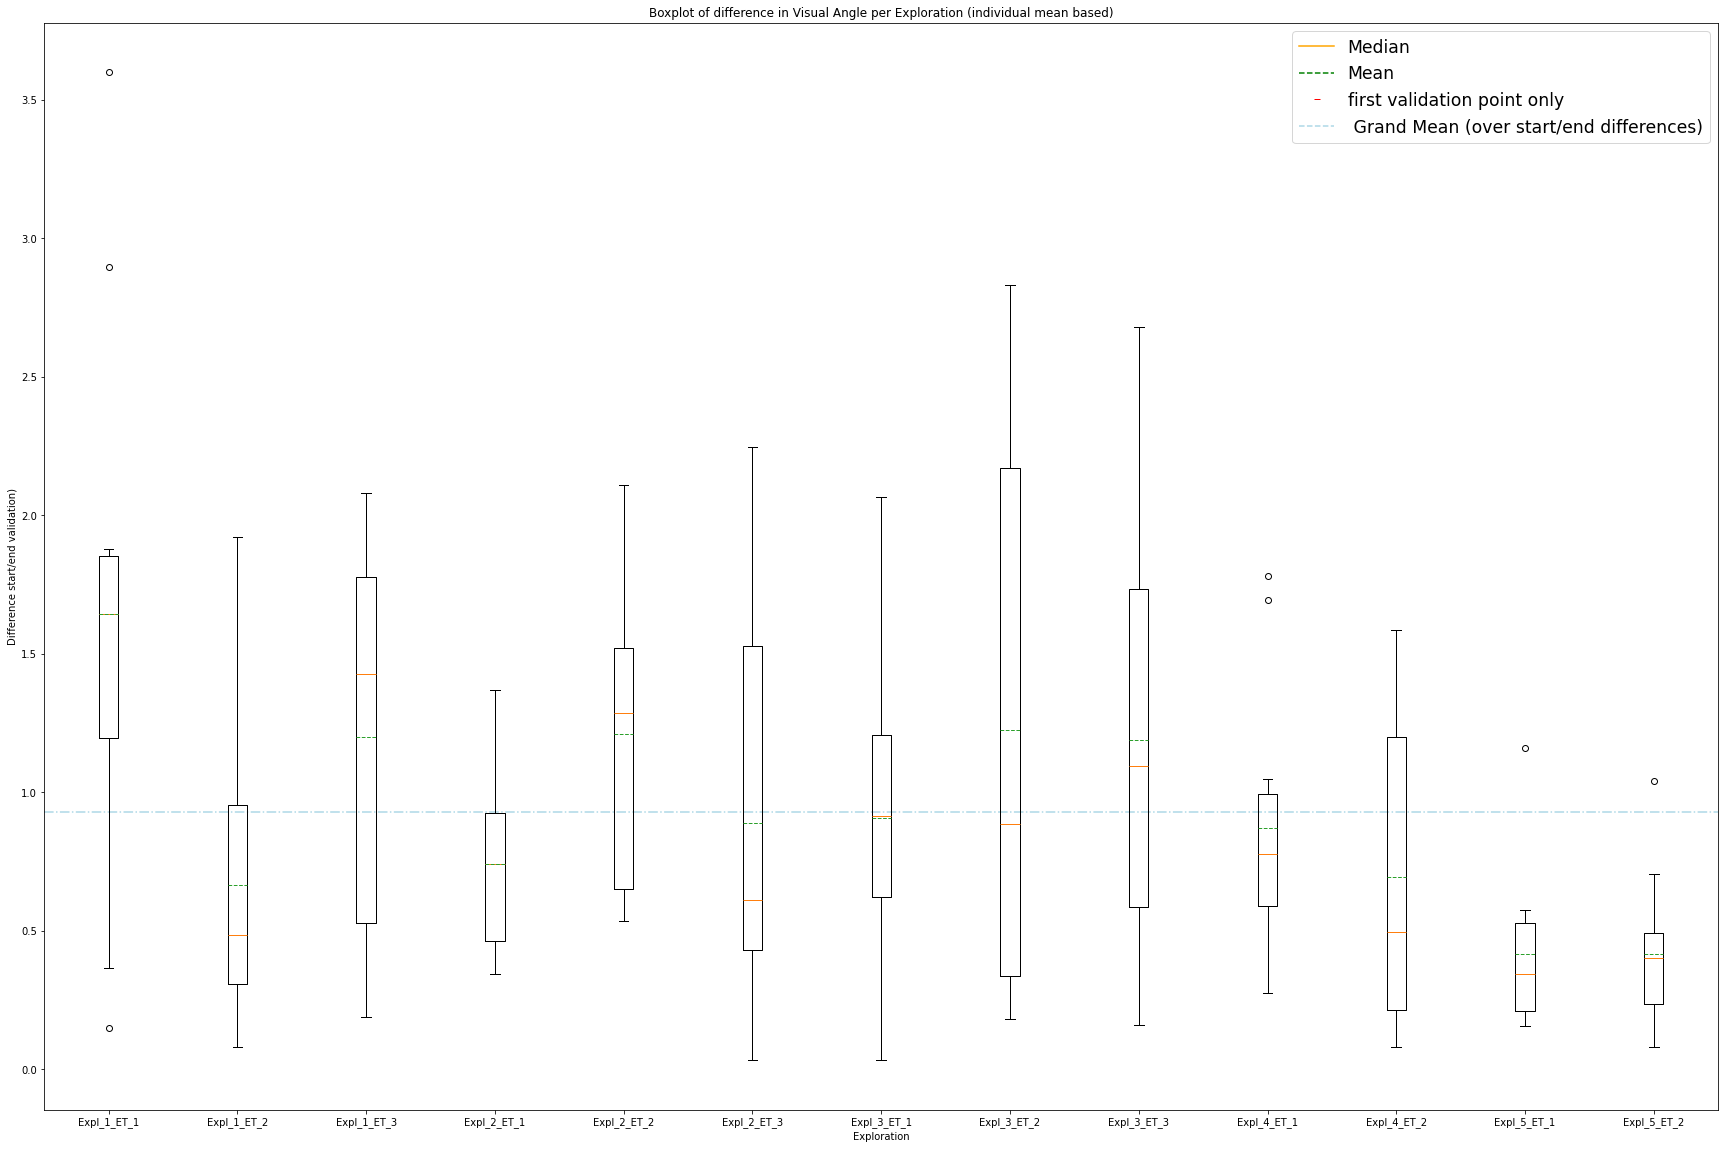

In [48]:
diff_start_end_df = create_diff_frame(visual_angle_df_w_h_mean_all)
grouped_diff_df = diff_start_end_df.groupby('folder')
# Plotting boxplot per exploration
i = 0
fig, ax = plt.subplots(figsize=(30,20))

for folder, group in grouped_diff_df:    
    ax.boxplot(group['start-end difference'], positions=[i], meanline=True, showmeans=True)
    i = i + 1
    
ax.axhline(y= np.mean(diff_start_end_df['start-end difference']), linestyle="-.",c='lightblue', zorder=1)

# Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
single_val_marker = plt.Line2D([], [], color='red', marker='_', linestyle='None',  label='first validation point only')
grand_mean_line = plt.Line2D([], [], color='lightblue', linestyle='--', label=' Grand Mean (over start/end differences)')

ax.legend(handles=[median_line, mean_line, single_val_marker, grand_mean_line], loc='upper right', fontsize='xx-large', title='')


ax.set_xticklabels(grouped_data.groups.keys())
ax.set_xlabel('Exploration')
ax.set_ylabel('Difference start/end validation)')
plt.title('Boxplot of difference in Visual Angle per Exploration (individual mean based)')

plt.show()

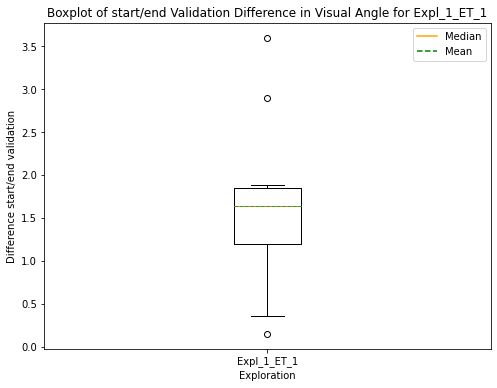

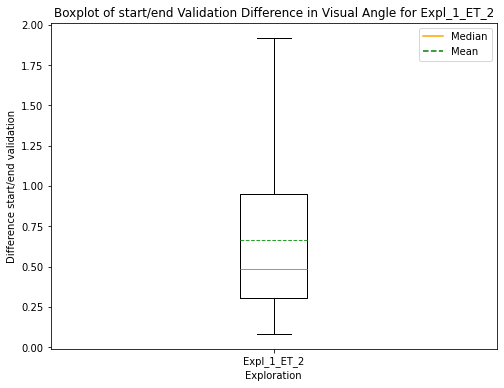

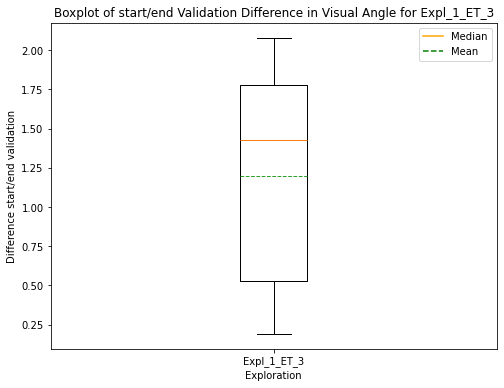

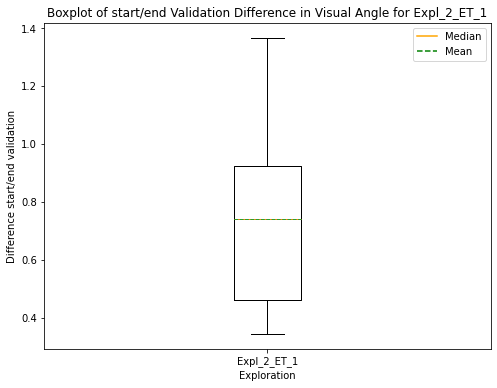

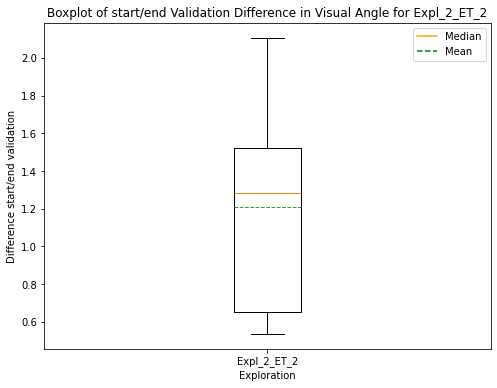

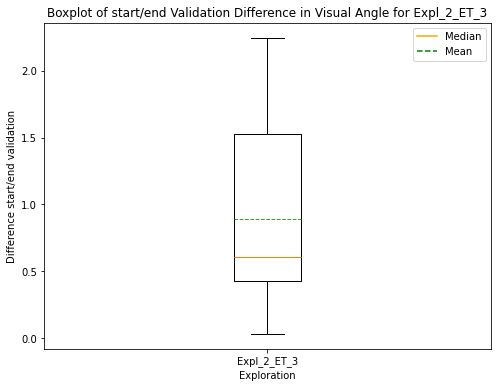

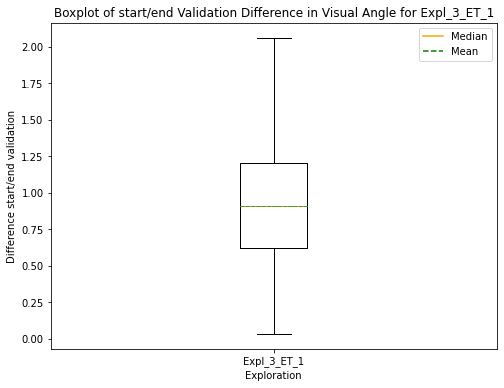

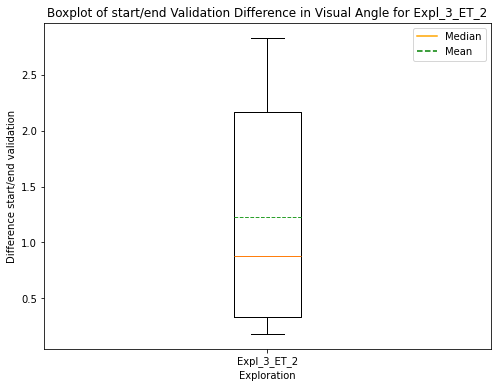

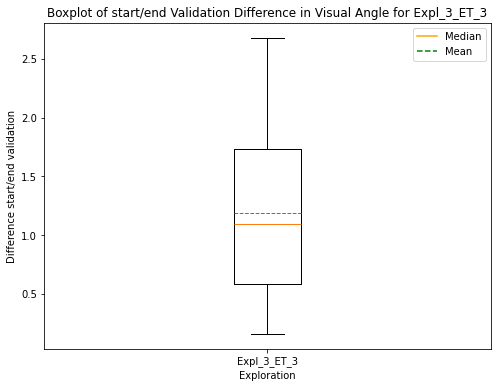

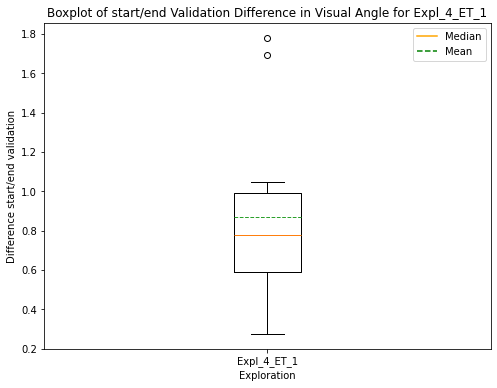

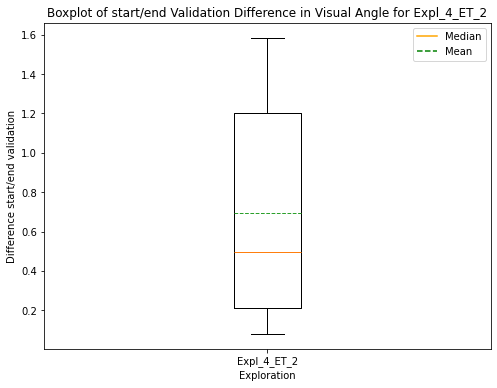

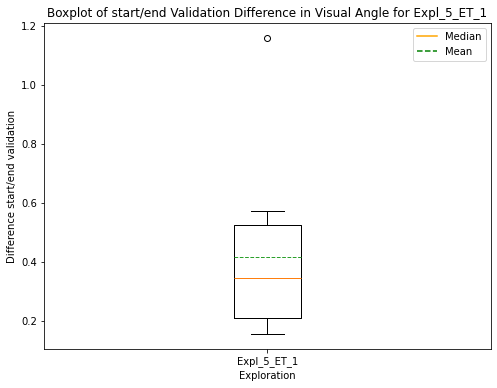

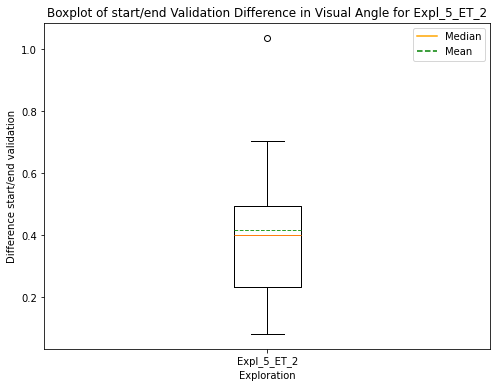

In [22]:

i=0

# Create separate plots for each exploration
for folder, group in grouped_diff_df:
    
    fig, ax = plt.subplots(figsize=(8, 6))  
    
    ax.boxplot(group['start-end difference'], positions=[0], meanline=True, showmeans=True)
    
    ax.set_title(f'Boxplot of start/end Validation Difference in Visual Angle for {folder}')
    ax.set_ylabel('Difference start/end validation')
    ax.set_xticklabels([folder])  # Set folder name as xticklabel
    ax.set_xlabel('Exploration')

    # Adding the custom legend
    median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
    mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')
    

    ax.legend(handles=[median_line, mean_line], loc='upper right', fontsize='medium', title='')

    i = i+1
    
    plt.show()


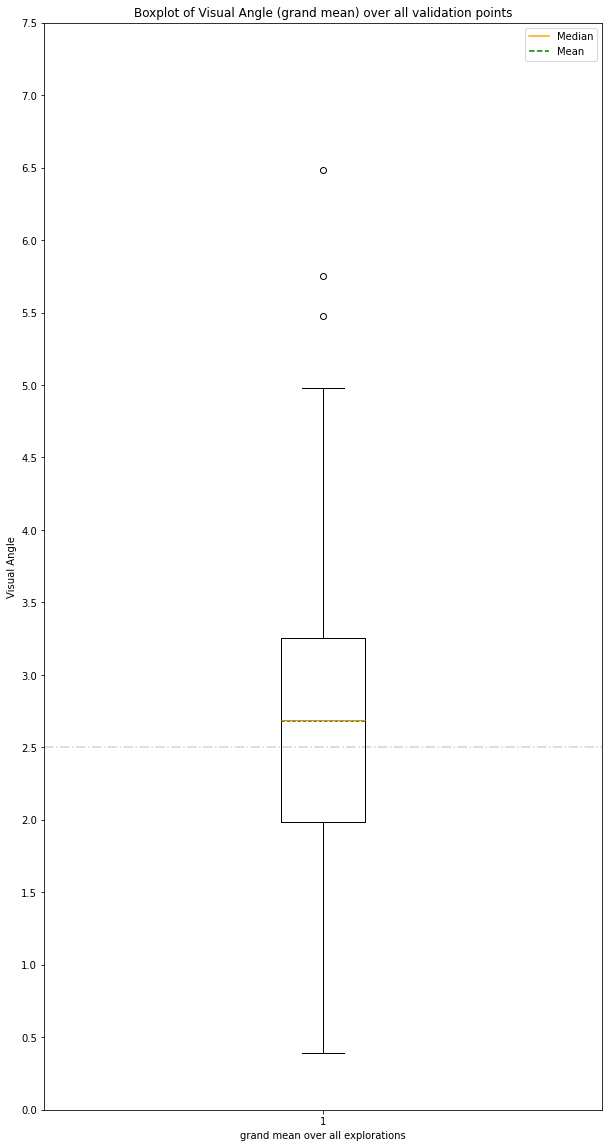

In [23]:
# Grouping by folder

visual_angle_df_w_h_mean_all

fig, ax = plt.subplots(figsize=(10, 20)) 

ax.boxplot(visual_angle_df_w_h_mean_all['visual angle'], meanline=True, showmeans=True)
ax.axhline(y=2.5, linestyle="-.",c="lightgrey",zorder=1)
#ax.scatter([0], np.mean(visual_angle_df_w_h_mean_all['visual angle']), marker="_", color='red', zorder=3)


    # Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')

ax.legend(handles=[median_line, mean_line], loc='upper right', fontsize='medium', title='')

ax.set_title(f'Boxplot of Visual Angle (grand mean) over all validation points')
ax.set_yticks((np.arange(0, 8, step=0.5)))
ax.set_ylabel('Visual Angle')
ax.set_xlabel('grand mean over all explorations')



plt.show()


## Grand mean over all start validations

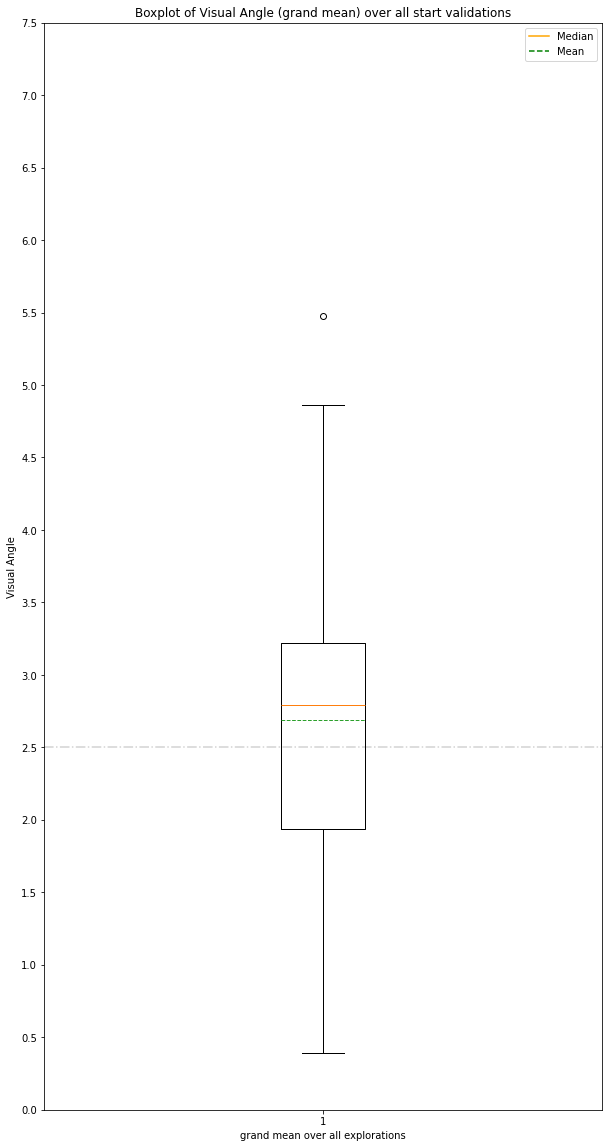

In [24]:
# Grouping by folder

start_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)


fig, ax = plt.subplots(figsize=(10, 20)) 

ax.boxplot(start_val_df['VA_start'], meanline=True, showmeans=True)
ax.axhline(y=2.5, linestyle="-.",c="lightgrey",zorder=1)


    # Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')

ax.legend(handles=[median_line, mean_line], loc='upper right', fontsize='medium', title='')

ax.set_title(f'Boxplot of Visual Angle (grand mean) over all start validations')
ax.set_yticks((np.arange(0, 8, step=0.5)))
ax.set_ylabel('Visual Angle')
ax.set_xlabel('grand mean over all explorations')



plt.show()


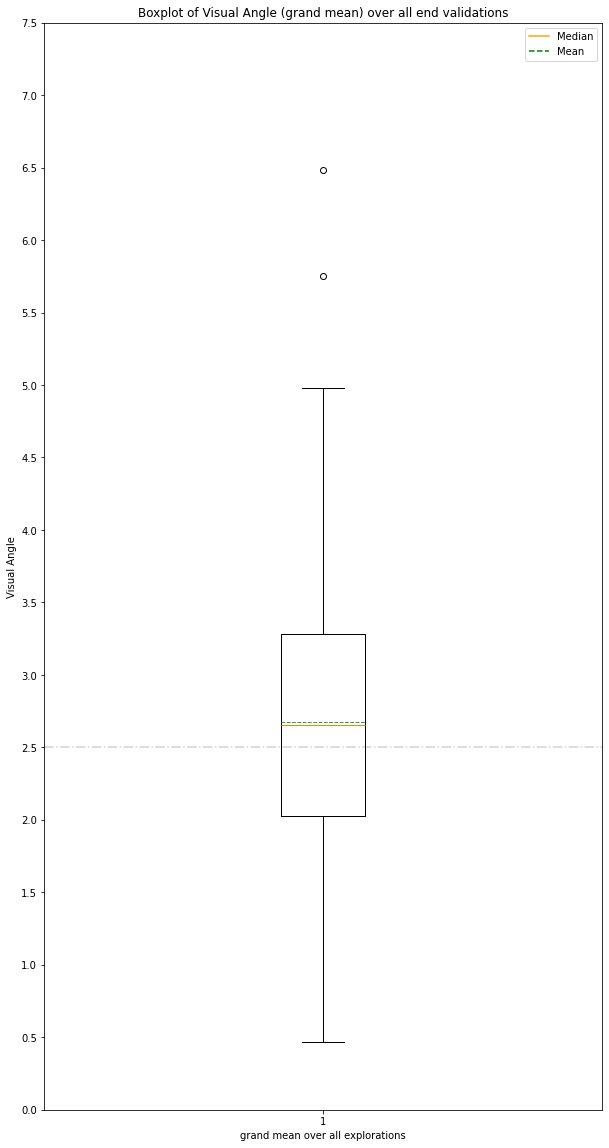

In [25]:
# Grouping by folder

end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)


fig, ax = plt.subplots(figsize=(10, 20)) 

ax.boxplot(end_val_df['VA_end'], meanline=True, showmeans=True)
ax.axhline(y=2.5, linestyle="-.",c="lightgrey",zorder=1)


    # Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')

ax.legend(handles=[median_line, mean_line], loc='upper right', fontsize='medium', title='')

ax.set_title(f'Boxplot of Visual Angle (grand mean) over all end validations')
ax.set_yticks((np.arange(0, 8, step=0.5)))
ax.set_ylabel('Visual Angle')
ax.set_xlabel('grand mean over all explorations')



plt.show()


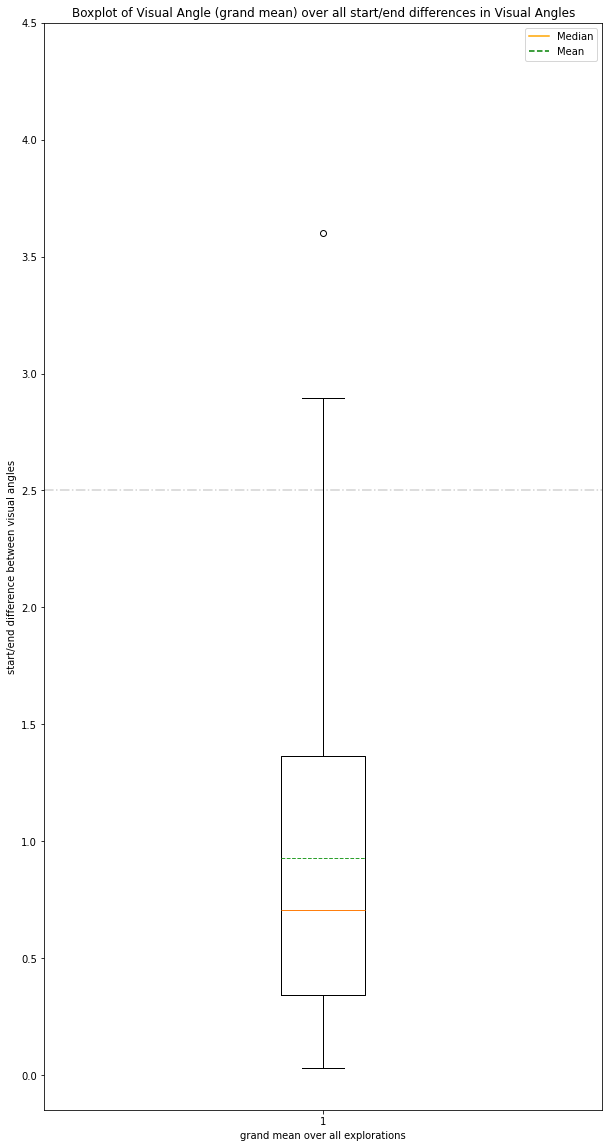

In [28]:
# Grouping by folder

start_end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)


fig, ax = plt.subplots(figsize=(10, 20)) 

ax.boxplot(start_end_val_df['start-end difference'], meanline=True, showmeans=True)
ax.axhline(y=2.5, linestyle="-.",c="lightgrey",zorder=1)


    # Adding the custom legend
median_line = plt.Line2D([], [], color='orange', linestyle='-', label='Median')
mean_line = plt.Line2D([], [], color='green', linestyle='--', label='Mean')

ax.legend(handles=[median_line, mean_line], loc='upper right', fontsize='medium', title='')

ax.set_title(f'Boxplot of Visual Angle (grand mean) over all start/end differences in Visual Angles')
ax.set_yticks((np.arange(0, 5, step=0.5)))
ax.set_ylabel('start/end difference between visual angles')
ax.set_xlabel('grand mean over all explorations')



plt.show()


# Plot for publication 

In [15]:
cmap=cm.roma
pal = cmap(np.linspace(0, 1, 10))
print(pal)

[[4.92325e-01 9.07870e-02 7.60000e-05 1.00000e+00]
 [6.01948e-01 3.20797e-01 8.30760e-02 1.00000e+00]
 [6.88849e-01 4.97239e-01 1.64248e-01 1.00000e+00]
 [7.85493e-01 7.07188e-01 3.34299e-01 1.00000e+00]
 [8.16266e-01 8.88952e-01 6.40490e-01 1.00000e+00]
 [6.43676e-01 8.99624e-01 8.27614e-01 1.00000e+00]
 [3.66446e-01 7.56186e-01 8.28409e-01 1.00000e+00]
 [1.92988e-01 5.66143e-01 7.58086e-01 1.00000e+00]
 [1.25859e-01 3.91517e-01 6.83451e-01 1.00000e+00]
 [9.82400e-03 1.92129e-01 5.96704e-01 1.00000e+00]]


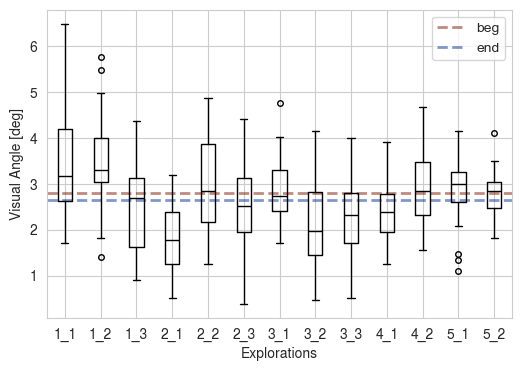

In [17]:
grouped_data = visual_angle_df_w_h_mean_all.groupby('folder')
start_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)
end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

cmap=cm.roma
pal = cmap(np.linspace(0, 1, 2))
plt.rcParams['font.family'] = 'TeX Gyre Heros'
pd.set_option('display.precision', 13)
# Plotting boxplot per folder
fig, ax = plt.subplots(figsize=(6,4))
sns.set_style("whitegrid") 

for i, (folder, group) in enumerate(grouped_data):    
    #ax.boxplot(group['visual angle'], positions=[i], meanline=False, showmeans=False,widths=0.4,medianprops=dict(color='black', linewidth=2))
    ax.boxplot(
        group['visual angle'],
        positions=[i],
        widths=0.4,
        meanline=False,
        showmeans=False,
        medianprops=dict(color='black', linewidth=1),
        boxprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
        flierprops=dict(marker='o', markersize=4, linestyle='none')  # optional: control outliers
    )
        
    
#ax.axhline(y=2.5, color="lightgrey", zorder=1, linestyle="-.")   
ax.axhline(y=np.median(start_val_df['VA_start']), color=pal[0], zorder=1, linestyle="--",linewidth=2,alpha=0.5)
ax.axhline(y=np.median(end_val_df['VA_end']), color=pal[1], zorder=1, linestyle="--",linewidth=2,alpha=0.5)

# Adding the custom legend
median_start = plt.Line2D([], [], color=pal[0], linestyle='--', label='beg',linewidth=2,alpha=0.5)
median_end = plt.Line2D([], [], color=pal[1], linestyle='--', label='end',linewidth=2,alpha=0.5)

#ax.legend(handles=[median_start, median_end], loc='upper right', fontsize=10, title='')
ax.legend(handles=[median_start, median_end], loc='upper right', title='')

# Original labels (dict_keys)
original_labels = list(grouped_data.groups.keys())
# Cleaned labels: extract the two numbers
cleaned_labels = [f"{s.split('_')[1]}_{s.split('_')[3]}" for s in original_labels]

ax.set_xticklabels(cleaned_labels)
ax.set_xlabel('Explorations')
ax.tick_params(axis='y')
ax.set_ylabel('Visual Angle [deg]')
#plt.title('Boxplot of Visual Angle (individual mean based) per Exploration')

plt.savefig("et_val_plot.png", bbox_inches="tight", pad_inches=0.3, dpi=400)
plt.show()

In [95]:
#Now, lets get the statistics:

start_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)
end_val_df = create_diff_frame(visual_angle_df_w_h_mean_all)

 
print("Start Median: ", np.median(start_val_df['VA_start']))
print("End Median: ", np.median(end_val_df['VA_end']))
# Interquartile range:
# start:
q25_start, q75_start = np.nanpercentile(start_val_df['VA_start'], [25, 75])
print(f"Start IQR: {q75_start - q25_start:.2f} ({q25_start:.2f}–{q75_start:.2f})")
# end:
q25_end, q75_end = np.nanpercentile(end_val_df['VA_end'], [25, 75])
print(f"End IQR: {q75_end - q25_end:.2f} ({q25_end:.2f}–{q75_end:.2f})")


# now: diff between beginning and end: 
medians_df = start_val_df.groupby('folder')[['VA_start', 'VA_end']].median().reset_index()
stat, p = wilcoxon(medians_df['VA_start'], medians_df['VA_end'])
print(f"Wilcoxon test statistic: {stat}, p-value: {p}")


Start Median:  2.7959144789017705
End Median:  2.6514177825408307
Start IQR: 1.28 (1.94–3.22)
End IQR: 1.26 (2.02–3.28)
Wilcoxon test statistic: 30.0, p-value: 0.305419921875


# Plotting Fixation and Saccade Durations

In [18]:
# load the slicing df:
slicing_folder = ".../preprocessing_data/synchro_ET-GPS"
slicing_df = pd.read_csv(f"{slicing_folder}/new_slicing-GPS-ET-timediff.csv")

# eye tracking folder
data_folder = ".../eyeTrackingData/raw"

# get the list of folders 
folder_list = os.listdir(data_folder)
# filter out folder_list containing "TestS_atLocation_"
folder_list = [s for s in folder_list if "TestS_atLocation_" not in s]

big_df = []
for i,v in enumerate(folder_list[:]):
    # Find the corresponding slicing points: 
    session_base = '_'.join(v.split('_')[:4]) 
    session_c1 = f"{session_base}_C1"
    session_c2 = f"{session_base}_C2"
    c1_row = slicing_df[slicing_df['session'] == session_c1]
    c2_row = slicing_df[slicing_df['session'] == session_c2]
    if c1_row.empty or c2_row.empty:
        print(f"Skipping {v} (missing session rows)")
        continue
    start_time = pd.to_datetime(c1_row['ET_end_time'].values[0])
    end_time = pd.to_datetime(c2_row['ET_start_time'].values[0])
    
    path = f'.../eyeTrackingData/raw/{v}'
    long_gaze = pd.read_csv(f"{path}/gaze.csv")
    # Convert timestamp to a more manageable unit if needed (e.g., milliseconds)
    long_gaze['timestamp'] = pd.to_datetime(long_gaze['timestamp [ns]'], unit='ns')
    # trim df
    gaze = long_gaze[(long_gaze['timestamp'] >= start_time) & (long_gaze['timestamp'] <= end_time)].copy()
    
    ### Fixation durations ###
    # Only rows with a valid fixation id
    fixation_mask = gaze['fixation id'].notna() & gaze['blink id'].isna()
    fixation_groups = gaze[fixation_mask].groupby('fixation id')
    # Get start/end times and duration
    fixation_durations = fixation_groups['timestamp'].agg(['first', 'last'])
    fixation_durations['duration_ns'] = (
        fixation_durations['last'] - fixation_durations['first']
    ).dt.total_seconds() * 1e9  # convert to ns
    fixation_durations['duration_ms'] = fixation_durations['duration_ns'] / 1e6
    fixation_durations = fixation_durations.reset_index()
    fixation_durations['event'] = 'fixation'
    fixation_durations = fixation_durations.rename(columns={'fixation id': 'event_id'})

    ### Saccade durations ##
    # Saccades = rows with no fixation and no blink
    is_saccade = gaze['fixation id'].isna() & gaze['blink id'].isna()
    # Identify consecutive saccade groups
    saccade_group_id = (is_saccade != is_saccade.shift()).cumsum()
    gaze['saccade id'] = np.where(is_saccade, saccade_group_id, np.nan)
    # Group and compute saccade durations
    saccade_groups = gaze[gaze['saccade id'].notna()].groupby('saccade id')
    saccade_durations = saccade_groups['timestamp'].agg(['first', 'last'])
    saccade_durations['duration_ns'] = (
        saccade_durations['last'] - saccade_durations['first']
    ).dt.total_seconds() * 1e9
    saccade_durations['duration_ms'] = saccade_durations['duration_ns'] / 1e6
    saccade_durations = saccade_durations.reset_index()
    saccade_durations['event'] = 'saccade'
    saccade_durations = saccade_durations.rename(columns={'saccade id': 'event_id'})
    

    ### Combine fixation and saccade events ###
    all_events = pd.concat([fixation_durations, saccade_durations], ignore_index=True)
    
    # Sort all events by start time
    all_events = all_events.sort_values(by='first').reset_index(drop=True)
    # Add session info
    all_events['session'] = session_base
    big_df.append(all_events)
# Combine all sessions
big_df = pd.concat(big_df, ignore_index=True)
display(big_df)

Skipping Expl_2_ET_3_2023-09-06_11-39-21_ET (missing session rows)


,event_id,first,last,duration_ns,duration_ms,event,session
0,1052.0,2023-09-05 09:04:18.953918803,2023-09-05 09:04:19.122510803,168592000.0,168.592,fixation,Expl_1_ET_1
1,2.0,2023-09-05 09:04:19.128996803,2023-09-05 09:04:19.163109803,34113000.0,34.113,saccade,Expl_1_ET_1
2,1053.0,2023-09-05 09:04:19.169681803,2023-09-05 09:04:19.338566803,168885000.0,168.885,fixation,Expl_1_ET_1
3,4.0,2023-09-05 09:04:19.344890803,2023-09-05 09:04:19.385096803,40206000.0,40.206,saccade,Expl_1_ET_1
4,1054.0,2023-09-05 09:04:19.388187803,2023-09-05 09:04:19.469378803,81191000.0,81.191,fixation,Expl_1_ET_1
...,...,...,...,...,...,...,...
40818,2416.0,2023-09-07 16:03:49.542222419,2023-09-07 16:03:49.835884419,293662000.0,293.662,fixation,Expl_5_ET_2
40819,3138.0,2023-09-07 16:03:49.842147419,2023-09-07 16:03:49.876483419,34336000.0,34.336,saccade,Expl_5_ET_2
40820,2417.0,2023-09-07 16:03:49.882958419,2023-09-07 16:03:50.114006419,231048000.0,231.048,fixation,Expl_5_ET_2
40821,3140.0,2023-09-07 16:03:50.117459419,2023-09-07 16:03:50.151579419,34120000.0,34.120,saccade,Expl_5_ET_2


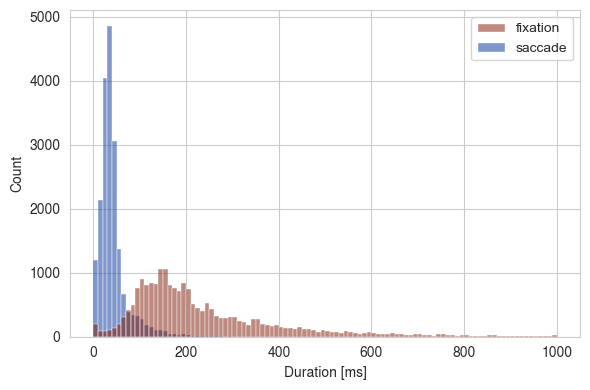

In [20]:
# Now let's plot the results:
filtered_df = big_df[big_df["duration_ms"] < 1000] # not not have such long events

cmap=cm.roma
pal = cmap(np.linspace(0, 1, 2)).tolist()
plt.rcParams['font.family'] = 'TeX Gyre Heros'

fig, ax = plt.subplots(figsize=(6,4))
sns.set_style("whitegrid") 
sns.histplot(data=filtered_df, x="duration_ms", hue="event", bins=100, kde=False, palette=pal)
plt.xlabel("Duration [ms]")
plt.ylabel("Count")
ax.tick_params(axis='x')
ax.tick_params(axis='y')
legend = plt.gca().get_legend()  # get current axes legend
legend.set_title(None)  

plt.tight_layout()
plt.savefig("et_fix_sac_dur.png", bbox_inches="tight", pad_inches=0.3, dpi=400)
plt.show()

In [175]:
#Now, lets get the statistics:
sacc = big_df[big_df["event"]=='saccade']
fix = big_df[big_df["event"]=='fixation']

 
#ax.axhline(y=2.5, color="lightgrey", zorder=1, linestyle="-.")   
print("Sacc: ", np.nanmedian(sacc['duration_ms']))
print("Fix: ", np.nanmedian(fix['duration_ms']))
# Interquartile range:
# start:
q25_sacc, q75_sacc = np.nanpercentile(sacc['duration_ms'], [25, 75])
print(f"Sacc IQR: {q75_sacc - q25_sacc:.2f} ({q25_sacc:.2f}–{q75_sacc:.2f})")
# end:
q25_fix, q75_fix = np.nanpercentile(fix['duration_ms'], [25, 75])
print(f"Fix IQR: {q75_fix - q25_fix:.2f} ({q25_fix:.2f}–{q75_fix:.2f})")


Sacc:  34.32
Fix:  190.54950000000002
Sacc IQR: 21.92 (24.98–46.89)
Fix IQR: 181.16 (128.27–309.43)
